# PRIMARY QUESTION: Which climate policy instruments are most effective in achieving their specific environmental goals?

## Prepare Dataframe

### Merge with Region

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

df_policies = pd.read_csv("new_data/climate_policy_database_policies_export.csv")

# drop unused columns
df_policies = df_policies.drop(columns=[
    "policy_id", 
    "policy_name", 
    "supranational_region", 
    "subnational_region", 
    "policy_city_or_local",
    # "policy_description",
    "stringency",
    "high_impact",
    "reference",
    "last_update",
    "impact_indicators.comments",
    "impact_indicators.name",
    "impact_indicators.value",
    "impact_indicators.base_year",
    "impact_indicators.target_year"
])

# function to convert string to list
def string_to_list(cell):
    return cell.split(",")

# convert string to list
df_policies["policy_instrument"] = df_policies["policy_instrument"].apply(string_to_list)
df_policies["sector"] = df_policies["sector"].apply(string_to_list)
df_policies["policy_type"] = df_policies["policy_type"].apply(string_to_list)
df_policies["policy_objective"] = df_policies["policy_objective"].apply(string_to_list)

# fill na
df_policies['start_date'] = df_policies['start_date'].fillna(df_policies['decision_date'])
df_policies['end_date'] = df_policies['end_date'].fillna(pd.Timestamp('now').year)
df_policies = df_policies.dropna(subset='start_date')

# load mapping region
df_region = pd.read_csv("new_data/region_mapping.csv")
df_region.head()

# merge region
df_policies = df_policies.merge(df_region, left_on='country_iso', right_on='alpha-3', how='left')
print(f"Number of policies: {len(df_policies)}")
df_policies.head()

Number of policies: 6247


country_iso country_update  \
0         ARE         Annual   
1         KAZ         Annual   
2         FRA       Sporadic   
3         BTN         Annual   
4         CAN         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
1               Environmental Code Kazakhstan (2021)      Country   
2   Energy Policy Framework (POPE, No. France (2005)      Country   
3                      Electricity Act Bhutan (2001)      Country   
4  GHGs Formally Designated as Pollutants Canada ...      Country   

                country                                  policy_instrument  \
0  United Arab Emirates              [Policy support,  Strategic planning]   
1            Kazakhstan      [Regulatory Instruments,  Obligation schemes]   
2                France  [RD&D funding,  Tax relief,  White certificate...   
3                Bhutan  [Policy support,  Institutional creation,  Str...   
4                Canada                           [Regulatory Instruments]   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
2               [Buildings,  General,  Industry]   
3                         [Electricity and heat]   
4                                      [General]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
1  The code regulates activities which may have a...   
2  • Reduce energy intensity by 2% annually betwe...   
3                                                NaN   
4                                                NaN   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
2  [Energy service demand reduction and resource ...      In force  ...   
3                   [Energy efficiency,  Renewables]      In force  ...   
4  [Energy service demand reduction and resource ...      In force  ...   

   alpha-2  alpha-3  country-code     iso_3166-2    region        sub-region  \
0       AE      ARE         784.0  ISO 3166-2:AE      Asia      Western Asia   
1       KZ      KAZ         398.0  ISO 3166-2:KZ      Asia      Central Asia   
2       FR      FRA         250.0  ISO 3166-2:FR    Europe    Western Europe   
3       BT      BTN          64.0  ISO 3166-2:BT      Asia     Southern Asia   
4       CA      CAN         124.0  ISO 3166-2:CA  Americas  Northern America   

  intermediate-region  region-code sub-region-code intermediate-region-code  
0                 NaN        142.0           145.0                      NaN  
1                 NaN        142.0           143.0                      NaN  
2                 NaN        150.0           155.0                      NaN  
3                 NaN        142.0            34.0                      NaN  
4                 NaN         19.0            21.0                      NaN  

[5 rows x 25 columns]

### Generate Policy Active Year

In [2]:
import datetime

# Function to create a range of years from start_date to end_date,
# handling NaN values, end_date = 0, and ensuring it doesn't exceed the current year
def create_year_range(row):
    current_year = datetime.datetime.now().year
    if pd.isna(row['start_date']) or pd.isna(row['end_date']) or row['end_date'] == 0:
        return []
    start_year = int(row['start_date'])
    end_year = min(int(row['end_date']), current_year)  # Limit the end year to the current year
    if start_year > end_year:  # Also check if start year is greater than end year
        return []
    return list(range(start_year, end_year + 1))

# Apply the function to each row
df_policies['active_years'] = df_policies.apply(create_year_range, axis=1)

# Explode the 'active_years' list into multiple rows
df_policies = df_policies.explode('active_years')

# Drop rows where 'active_year' is NaN which results from empty lists or incorrect year ranges
df_policies = df_policies.dropna(subset=['active_years'])

# Rename the column for clarity and convert 'active_year' to integer
df_policies.rename(columns={'active_years': 'active_year'}, inplace=True)
df_policies['active_year'] = df_policies['active_year'].astype(int)

# Display the first few rows to verify
df_policies.head()

country_iso country_update  \
0         ARE         Annual   
0         ARE         Annual   
1         KAZ         Annual   
1         KAZ         Annual   
1         KAZ         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
0  National Hydrogen Strategy United Arab Emirate...      Country   
1               Environmental Code Kazakhstan (2021)      Country   
1               Environmental Code Kazakhstan (2021)      Country   
1               Environmental Code Kazakhstan (2021)      Country   

                country                              policy_instrument  \
0  United Arab Emirates          [Policy support,  Strategic planning]   
0  United Arab Emirates          [Policy support,  Strategic planning]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   
1            Kazakhstan  [Regulatory Instruments,  Obligation schemes]   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
1                                      [General]   
1                                      [General]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
0  The National Hydrogen Strategy 2050 aims to su...   
1  The code regulates activities which may have a...   
1  The code regulates activities which may have a...   
1  The code regulates activities which may have a...   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   
1  [Energy service demand reduction and resource ...      In force  ...   

   alpha-3  country-code     iso_3166-2 region    sub-region  \
0      ARE         784.0  ISO 3166-2:AE   Asia  Western Asia   
0      ARE         784.0  ISO 3166-2:AE   Asia  Western Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   
1      KAZ         398.0  ISO 3166-2:KZ   Asia  Central Asia   

  intermediate-region region-code  sub-region-code intermediate-region-code  \
0                 NaN       142.0            145.0                      NaN   
0                 NaN       142.0            145.0                      NaN   
1                 NaN       142.0            143.0                      NaN   
1                 NaN       142.0            143.0                      NaN   
1                 NaN       142.0            143.0                      NaN   

  active_year  
0        2023  
0        2024  
1        2021  
1        2022  
1        2023  

[5 rows x 26 columns]

### Merge with world population data

In [3]:
df_wpp = pd.read_csv('new_data/WPP.csv')
df_wpp = df_wpp.loc[df_wpp['Variant'] == 'Medium']
df_policies = df_policies.merge(df_wpp, left_on=['country', 'active_year'], right_on=['Location', 'Time'], how='inner')
df_policies.head()

country_iso country_update  \
0         ARE         Annual   
1         ARE         Annual   
2         ARE         Annual   
3         ARE         Annual   
4         ARE         Annual   

                                        policy_title jurisdiction  \
0  National Hydrogen Strategy United Arab Emirate...      Country   
1  Green Growth Strategy United Arab Emirates (2012)      Country   
2  Desalination Efficiency United Arab Emirates (...      Country   
3  Net Zero by 2050 pathway United Arab Emirates ...      Country   
4  Renewable Energy Education and RD&D Strategy U...      Country   

                country                                  policy_instrument  \
0  United Arab Emirates              [Policy support,  Strategic planning]   
1  United Arab Emirates              [Policy support,  Strategic planning]   
2  United Arab Emirates                       [Infrastructure investments]   
3  United Arab Emirates  [Climate strategy,  Political & non-binding cl...   
4  United Arab Emirates  [Information and education,  Policy support,  ...   

                                          sector  \
0  [Electricity and heat,  Industry,  Transport]   
1                                      [General]   
2                                     [Industry]   
3                                      [General]   
4            [Electricity and heat,  Renewables]   

                                  policy_description  \
0  The National Hydrogen Strategy 2050 aims to su...   
1  The Strategy provides national and emirate-lev...   
2  New desalination plants being built in the UAE...   
3  The pathway defines the country’s climate ambi...   
4                                                NaN   

                                         policy_type policy_status  ...  \
0    [Other low-carbon technologies and fuel switch]      In force  ...   
1  [Energy efficiency,  Energy service demand red...      In force  ...   
2                                [Energy efficiency]         Ended  ...   
3  [Energy efficiency,  Energy service demand red...      In force  ...   
4                                       [Renewables]      In force  ...   

   LocID              Location  VarID Variant  Time MidPeriod   PopMale  \
0    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
1    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
2    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
3    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   
4    784  United Arab Emirates      2  Medium  2023    2023.5  6970.756   

   PopFemale  PopTotal PopDensity  
0   3194.394  10165.15    121.593  
1   3194.394  10165.15    121.593  
2   3194.394  10165.15    121.593  
3   3194.394  10165.15    121.593  
4   3194.394  10165.15    121.593  

[5 rows x 36 columns]

## Mapping Sectors
with the help of GPT, eight distrinct sectors can be identified.

In [4]:
# Define the sector groupings
sector_group_mapping = {
    'Electricity and heat': 'Energy Production and Supply',
    'Renewables': 'Energy Production and Supply',
    'Gas': 'Energy Production and Supply',
    'Coal': 'Energy Production and Supply',
    'Nuclear': 'Energy Production and Supply',
    'Oil': 'Energy Production and Supply',
    'Fossil fuel exploration and production': 'Energy Production and Supply',
    
    'Transport': 'Transportation',
    'Light-duty vehicles': 'Transportation',
    'Low-emissions mobility': 'Transportation',
    'Heavy-duty vehicles': 'Transportation',
    'Shipping': 'Transportation',
    'Rail': 'Transportation',
    'Air': 'Transportation',
    
    'Buildings': 'Buildings and Infrastructure',
    'Appliances': 'Buildings and Infrastructure',
    'Heating and cooling': 'Buildings and Infrastructure',
    'Hot water and cooking': 'Buildings and Infrastructure',
    'Construction': 'Buildings and Infrastructure',
    
    'Industry': 'Industrial Processes',
    'Industrial energy related': 'Industrial Processes',
    'Industrial process CO2': 'Industrial Processes',
    'Industrial N2O': 'Industrial Processes',
    
    'Agriculture and forestry': 'Agriculture and Forestry',
    'Forestry': 'Agriculture and Forestry',
    'Agricultural CH4': 'Agriculture and Forestry',
    'Agricultural CO2': 'Agriculture and Forestry',
    'Agricultural N2O': 'Agriculture and Forestry',
    
    'Waste CH4': 'Waste Management',
    
    'Fluorinated gases': 'Emission Reduction Technologies',
    'CCS': 'Emission Reduction Technologies',
    'Negative emissions': 'Emission Reduction Technologies',
    
    'General': 'General'
}

exploded = df_policies.explode("sector")
exploded["sector"] = exploded["sector"].str.strip()

# Map sectors to their respective groups
exploded["sector_group"] = exploded["sector"].map(sector_group_mapping)

# Display the grouped sectors and their counts
sector_group_counts = exploded["sector_group"].value_counts()

# Display the resulting DataFrame for verification
print(sector_group_counts)

sector_group
Energy Production and Supply       48875
Buildings and Infrastructure       26522
Transportation                     25984
General                            18554
Industrial Processes               13746
Agriculture and Forestry           11107
Emission Reduction Technologies     1814
Waste Management                     607
Name: count, dtype: int64


# 1. Correlation Between Policy Instruments and Achievement of Policy Objectives Across Sectors

## Energy Production and Supply

In [5]:
# Define the policy instrument groupings
policy_instrument_group_mapping = {
    # Support and Strategic Measures
    'Policy support': 'Support and Strategic Measures',
    'Strategic planning': 'Support and Strategic Measures',
    'Institutional creation': 'Support and Strategic Measures',
    'Monitoring': 'Support and Strategic Measures',
    'Infrastructure investments': 'Support and Strategic Measures',
    'Funds to sub-national governments': 'Support and Strategic Measures',
    'Advice or aid in implementation': 'Support and Strategic Measures',
    'Professional training and qualification': 'Support and Strategic Measures',
    'Negotiated agreements (public-private sector)': 'Support and Strategic Measures',
    'Voluntary approaches': 'Support and Strategic Measures',
    'Public voluntary schemes': 'Support and Strategic Measures',
    'Unilateral commitments (private sector)': 'Support and Strategic Measures',
    'Auditing': 'Support and Strategic Measures',
    'Barrier removal': 'Support and Strategic Measures',
    'Removal of split incentives (landlord tenant problem)': 'Support and Strategic Measures',

    # Regulatory Instruments
    'Codes and standards': 'Regulatory Instruments',
    'Sectoral standards': 'Regulatory Instruments',
    'Building codes and standards': 'Regulatory Instruments',
    'Product standards': 'Regulatory Instruments',
    'Industrial air pollution standards': 'Regulatory Instruments',
    'Vehicle fuel-economy and emissions standards': 'Regulatory Instruments',
    'Vehicle air pollution standards': 'Regulatory Instruments',
    'Procurement rules': 'Regulatory Instruments',
    'Other mandatory requirements': 'Regulatory Instruments',
    'Obligation schemes': 'Regulatory Instruments',
    'Grid access and priority for renewables': 'Regulatory Instruments',
    'Feed-in tariffs or premiums': 'Regulatory Instruments',
    'Regulatory Instruments': 'Regulatory Instruments',
    'User charges': 'Regulatory Instruments',

    # Economic Instruments
    'Economic instruments': 'Economic Instruments',
    'Grants and subsidies': 'Economic Instruments',
    'Fiscal or financial incentives': 'Economic Instruments',
    'Tax relief': 'Economic Instruments',
    'Energy and other taxes': 'Economic Instruments',
    'Loans': 'Economic Instruments',
    'Direct investment': 'Economic Instruments',
    'Market-based instruments': 'Economic Instruments',
    'GHG emission reduction crediting and offsetting mechanism': 'Economic Instruments',
    'GHG emissions allowances': 'Economic Instruments',
    'White certificates': 'Economic Instruments',
    'Green certificates': 'Economic Instruments',
    'CO2 taxes': 'Economic Instruments',
    'Retirement premium': 'Economic Instruments',
    'Net metering': 'Economic Instruments',
    'Removal of fossil fuel subsidies': 'Economic Instruments',
    'Tendering schemes': 'Economic Instruments',

    # Targets and Commitments
    'Renewable energy target': 'Targets and Commitments',
    'Energy efficiency target': 'Targets and Commitments',
    'GHG reduction target': 'Targets and Commitments',
    'Formal & legally binding renewable energy target': 'Targets and Commitments',
    'Formal & legally binding energy efficiency target': 'Targets and Commitments',
    'Formal & legally binding GHG reduction target': 'Targets and Commitments',
    'Political & non-binding renewable energy target': 'Targets and Commitments',
    'Political & non-binding energy efficiency target': 'Targets and Commitments',
    'Political & non-binding GHG reduction target': 'Targets and Commitments',
    'Climate strategy': 'Targets and Commitments',
    'Formal & legally binding climate strategy': 'Targets and Commitments',
    'Target': 'Targets and Commitments',
    'Political & non-binding climate strategy': 'Targets and Commitments',

    # Research, Development, and Innovation
    'Research & Development and Deployment (RD&D)': 'Research, Development, and Innovation',
    'RD&D funding': 'Research, Development, and Innovation',
    'Research programme': 'Research, Development, and Innovation',
    'Technology development': 'Research, Development, and Innovation',
    'Technology deployment and diffusion': 'Research, Development, and Innovation',
    'Demonstration project': 'Research, Development, and Innovation',

    # Information and Education
    'Information and education': 'Information and Education',
    'Information provision': 'Information and Education',
    'Performance label': 'Information and Education',
    'Endorsement label': 'Information and Education',
    'Comparison label': 'Information and Education'
}

In [6]:
df_energy = exploded[exploded["sector_group"] == "Energy Production and Supply"]
df_energy = df_energy.explode("policy_instrument")
df_energy["policy_instrument"] = df_energy["policy_instrument"].str.strip()

# Map policy instruments to their respective groups
df_energy["policy_instrument_group"] = df_energy["policy_instrument"].map(policy_instrument_group_mapping)

# Display the grouped policy instruments and their counts
policy_group_counts = df_energy["policy_instrument_group"].value_counts()

policy_group_counts

policy_instrument_group
Support and Strategic Measures           29647
Economic Instruments                     28281
Regulatory Instruments                   24810
Targets and Commitments                  15141
Research, Development, and Innovation    13622
Information and Education                 5521
Name: count, dtype: int64

### 1) How do Support and Strategic Measures influence the performance and stability of the Energy Production and Supply sector?

**Data Required for Analysis**. 
1. Policy Instrument Data:
* Number of Policies in each of the grouped categories:
    * Policy Support and Strategic Planning
    * Infrastructure and Financial Investments
    * Implementation and Capacity Building
    * Collaborative and Voluntary Approaches
* Geographical Scope: Data on policy counts at global, regional, and national levels.
* Time Frame: Historical data on the number of policies to observe trends over time.

2. Performance Metrics Data:
* Energy Production and Supply Metrics:
    * Data on energy access (percentage of population with access to electricity).
    * Data on renewable energy capacity and share in the energy mix.
    * Data on fossil fuel and nuclear energy production and consumption.
    * Data on CO₂ and greenhouse gas emissions from energy production.
* Environmental Impact Metrics:
    * Data on air pollution levels and emissions from energy sources.
    * Data on water use and stress related to energy production.
    * Data on the impact of energy production on biodiversity and forests.
    * Data on incidents related to oil spills and plastic pollution if relevant.

Define for storing the corrlation

In [7]:
data = {
    "graph_name": [],
    "year": [],
    "correlation_value": [],
    "num_policies": []
}

Identify policy_type for each sector

In [8]:
df_sub = df_energy[df_energy["policy_instrument_group"] == "Economic Instruments"]
df_sub = df_sub.explode("policy_type")
df_sub["policy_type"] = df_sub["policy_type"].str.strip()
df_sub = df_sub[df_sub["policy_type"] != "Unknown"]
df_sub.head()

country_iso country_update  \
9          ARE         Annual   
9          ARE         Annual   
18         ARE         Annual   
18         ARE         Annual   
20         ARE         Annual   

                                         policy_title        jurisdiction  \
9   Overseas Renewable Energy Development Assistan...             Country   
9   Overseas Renewable Energy Development Assistan...             Country   
18  Overseas Renewable Energy Investment Strategy ...             Country   
18  Overseas Renewable Energy Investment Strategy ...             Country   
20  Renewable Energy Deployment Strategy United Ar...  Subnational region   

                 country     policy_instrument                sector  \
9   United Arab Emirates  Economic instruments  Electricity and heat   
9   United Arab Emirates  Economic instruments            Renewables   
18  United Arab Emirates  Economic instruments  Electricity and heat   
18  United Arab Emirates  Economic instruments            Renewables   
20  United Arab Emirates  Grants and subsidies  Electricity and heat   

                                   policy_description policy_type  \
9                                                 NaN  Renewables   
9                                                 NaN  Renewables   
18                                                NaN  Renewables   
18                                                NaN  Renewables   
20  Abu Dhabi has set a target of 7% renewable ene...  Renewables   

   policy_status  ...  VarID  Variant  Time MidPeriod   PopMale PopFemale  \
9       In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
9       In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
18      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
18      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
20      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   

    PopTotal  PopDensity                  sector_group policy_instrument_group  
9   10165.15     121.593  Energy Production and Supply    Economic Instruments  
9   10165.15     121.593  Energy Production and Supply    Economic Instruments  
18  10165.15     121.593  Energy Production and Supply    Economic Instruments  
18  10165.15     121.593  Energy Production and Supply    Economic Instruments  
20  10165.15     121.593  Energy Production and Supply    Economic Instruments  

[5 rows x 38 columns]

Number of policies for each policy type and sector

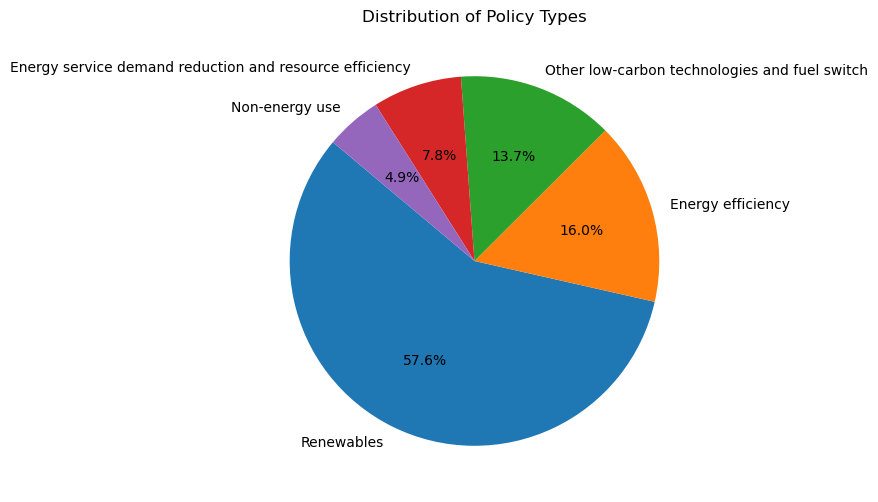

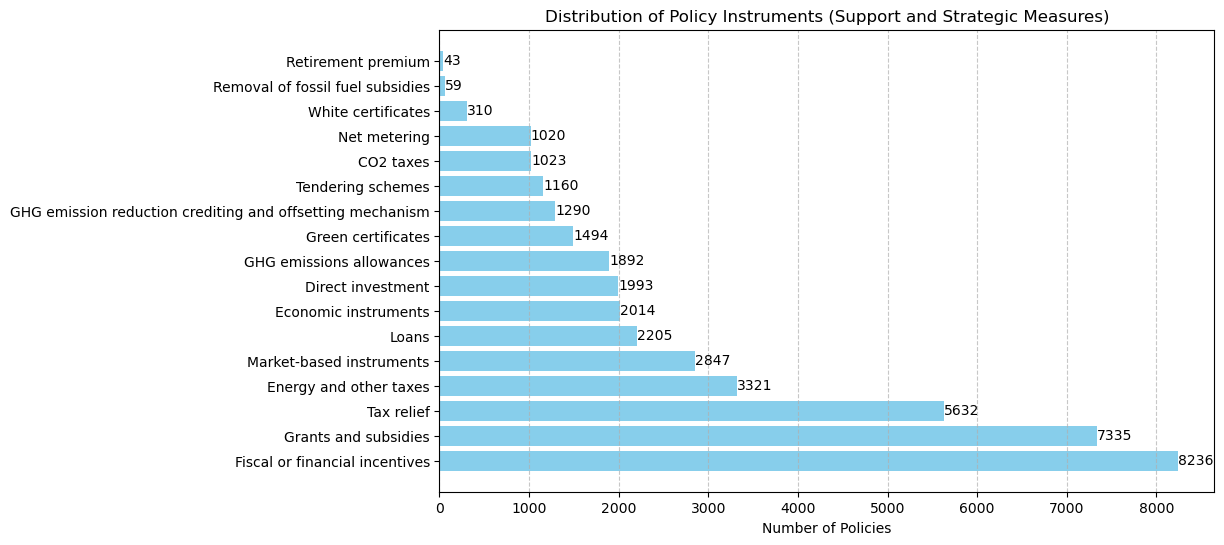

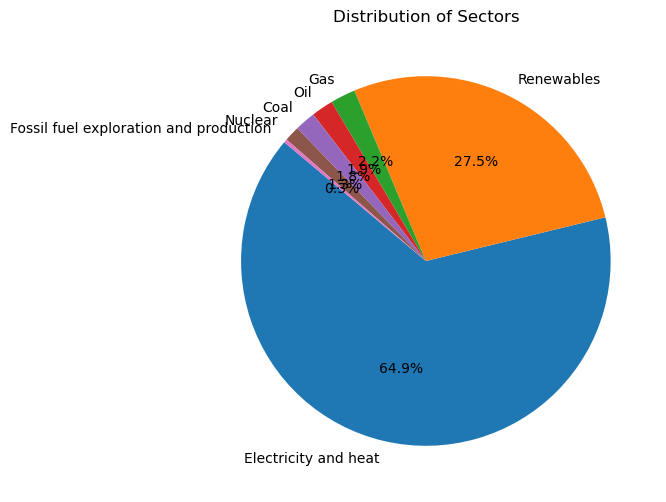

In [9]:
import matplotlib.pyplot as plt

# Value counts for policy_type and sector
policy_type_counts = df_sub["policy_type"].value_counts()
policy_instrument_counts = df_sub["policy_instrument"].value_counts()
policy_sector_counts = df_sub["sector"].value_counts()

# Create pie chart for policy_type in a separate figure
plt.figure(figsize=(8, 6))
plt.pie(policy_type_counts, labels=policy_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Policy Types')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(policy_instrument_counts.index, policy_instrument_counts.values, color='skyblue')
plt.xlabel('Number of Policies')
plt.title('Distribution of Policy Instruments (Economic Instruments)')

# Add value labels to the bars
for index, value in enumerate(policy_instrument_counts.values):
    plt.text(value, index, f'{value}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(policy_sector_counts, labels=policy_sector_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sectors')
plt.show()

#### Number of Renewable Energy Policies vs. Share of primary energy consumption from renewable sources

In [10]:
df_renewables_policies = df_sub[df_sub["policy_type"] == "Renewables"]
df_renewables_policies.head()

country_iso country_update  \
9          ARE         Annual   
9          ARE         Annual   
18         ARE         Annual   
18         ARE         Annual   
20         ARE         Annual   

                                         policy_title        jurisdiction  \
9   Overseas Renewable Energy Development Assistan...             Country   
9   Overseas Renewable Energy Development Assistan...             Country   
18  Overseas Renewable Energy Investment Strategy ...             Country   
18  Overseas Renewable Energy Investment Strategy ...             Country   
20  Renewable Energy Deployment Strategy United Ar...  Subnational region   

                 country     policy_instrument                sector  \
9   United Arab Emirates  Economic instruments  Electricity and heat   
9   United Arab Emirates  Economic instruments            Renewables   
18  United Arab Emirates  Economic instruments  Electricity and heat   
18  United Arab Emirates  Economic instruments            Renewables   
20  United Arab Emirates  Grants and subsidies  Electricity and heat   

                                   policy_description policy_type  \
9                                                 NaN  Renewables   
9                                                 NaN  Renewables   
18                                                NaN  Renewables   
18                                                NaN  Renewables   
20  Abu Dhabi has set a target of 7% renewable ene...  Renewables   

   policy_status  ...  VarID  Variant  Time MidPeriod   PopMale PopFemale  \
9       In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
9       In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
18      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
18      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   
20      In force  ...      2   Medium  2023    2023.5  6970.756  3194.394   

    PopTotal  PopDensity                  sector_group policy_instrument_group  
9   10165.15     121.593  Energy Production and Supply    Economic Instruments  
9   10165.15     121.593  Energy Production and Supply    Economic Instruments  
18  10165.15     121.593  Energy Production and Supply    Economic Instruments  
18  10165.15     121.593  Energy Production and Supply    Economic Instruments  
20  10165.15     121.593  Energy Production and Supply    Economic Instruments  

[5 rows x 38 columns]

Number of Renewable Energy Policies vs Share of primary energy consumption from renewable sources

In [11]:
df_share_energy_consump = pd.read_csv("new_data/energy/renewable-share-energy.csv")
df_share_energy_consump = df_share_energy_consump.dropna()
df_share_energy_consump.head()

Entity Code  Year  Renewables (% equivalent primary energy)
116  Algeria  DZA  1965                                  4.763068
117  Algeria  DZA  1966                                  3.518747
118  Algeria  DZA  1967                                  4.291954
119  Algeria  DZA  1968                                  5.486195
120  Algeria  DZA  1969                                  3.182763

In [12]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_renewables_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_renewables_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_consump,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Renewables (% equivalent primary energy)',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Renewables (% equivalent primary energy)',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Renewables (% equivalent primary energy)'])
    plt.title(f'Correlation between Number of Policies and Share of primary energy consumption from renewable sources in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Renewables (% equivalent primary energy)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2022, min=2000), Output()), _dom_classes=…

In [13]:
# Function to calculate and store data without plotting
def calculate_and_store_data(df, graph_name, col):
    for year in df['Year'].unique():
        # Filter the data for the selected year
        df_year = df[df['Year'] == year]
        
        if df_year.empty:
            continue

        # Calculate the correlation between policy count and renewable energy consumption
        correlation = df_year['policy_count'].corr(df_year[col])
        num_policies = df_year['policy_count'].sum()

        # Store the data in the dictionary
        data['graph_name'].append(graph_name)
        data['year'].append(year)
        data['correlation_value'].append(correlation)
        data['num_policies'].append(num_policies)

# Run the function to calculate and store the data
calculate_and_store_data(df_combined, 'renewables_consumption', 'Renewables (% equivalent primary energy)')

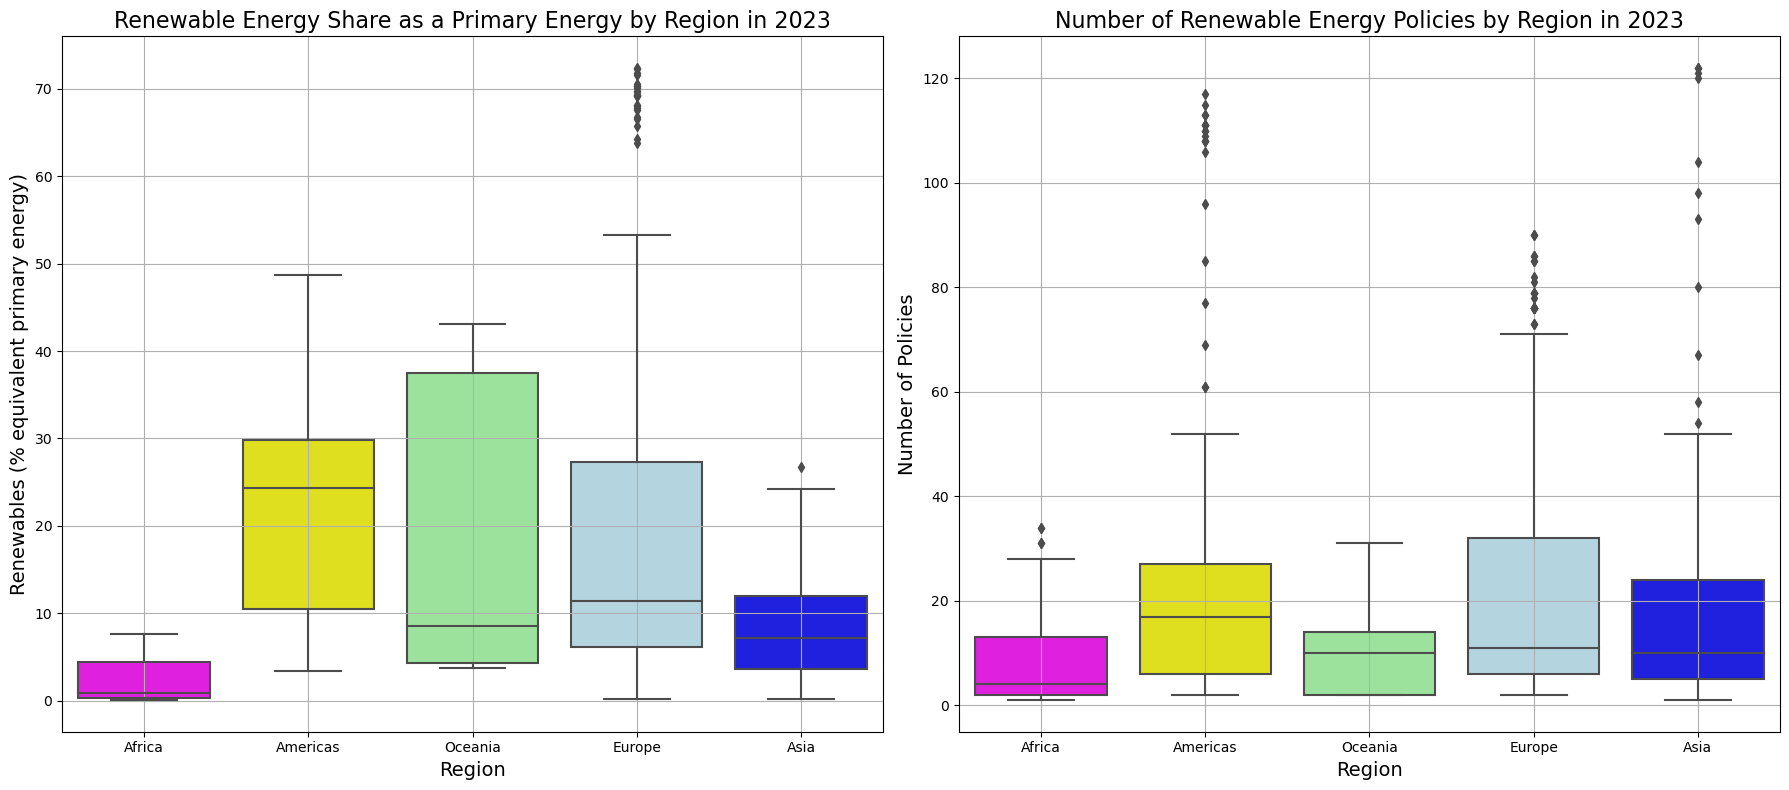

In [14]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Renewables (% equivalent primary energy)',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Renewable Energy Share as a Primary Energy by Region in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Renewables (% equivalent primary energy)', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Renewable Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

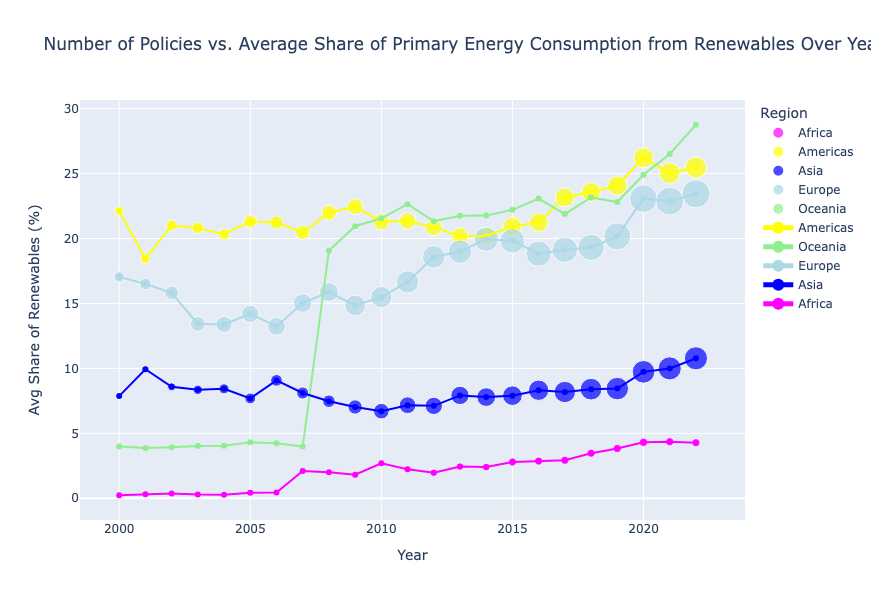

In [15]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Renewables (% equivalent primary energy)': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
region_agg.rename(columns={'Renewables (% equivalent primary energy)': 'Avg Share of Renewables'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_renewables_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Avg Share of Renewables',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Average Share of Primary Energy Consumption from Renewables Over Years',
        labels={'policy_count': 'Number of Policies', 'Avg Share of Renewables': 'Avg Share of Renewables (%)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Avg Share of Renewables'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Renewables: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Avg Share of Renewables (%)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_renewables_interactive(region_agg)

#### Number of Renewable Energy Policies vs Share of electricity production from renewables

In [16]:
df_share_energy_prod = pd.read_csv("new_data/energy/modern-renewable-prod.csv")
df_share_energy_prod = df_share_energy_prod.dropna()
df_share_energy_prod.head()

Entity Code  Year  Electricity from wind - TWh  \
24  Afghanistan  AFG  2000                          0.0   
25  Afghanistan  AFG  2001                          0.0   
26  Afghanistan  AFG  2002                          0.0   
27  Afghanistan  AFG  2003                          0.0   
28  Afghanistan  AFG  2004                          0.0   

    Electricity from hydro - TWh  Electricity from solar - TWh  \
24                          0.31                           0.0   
25                          0.50                           0.0   
26                          0.56                           0.0   
27                          0.63                           0.0   
28                          0.56                           0.0   

    Other renewables including bioenergy - TWh  
24                                         0.0  
25                                         0.0  
26                                         0.0  
27                                         0.0  
28                                         0.0

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Sample Data (Replace this with your actual DataFrame loading code)
# df_renewables_policies = pd.read_csv("renewable_policies.csv")
# df_share_energy_consump = pd.read_csv("share_energy_consumption.csv")

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_renewables_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_renewables_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_prod,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year, y_column):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y=y_column,
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y=y_column,
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year[y_column])
    plt.title(f'Correlation between Number of Policies and {y_column} in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel(y_column)
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Create a dropdown widget for column selection
column_selector = widgets.Dropdown(
    options=[
        'Electricity from wind - TWh',
        'Electricity from hydro - TWh',
        'Electricity from solar - TWh',
        'Other renewables including bioenergy - TWh'
    ],
    value='Electricity from wind - TWh',
    description='Y-axis:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year, y_column):
    plot_correlation_fixed_colors(df_combined, year, y_column)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors, y_column=column_selector)

interactive(children=(IntSlider(value=2000, description='Year:', max=2023, min=2000), Dropdown(description='Y-…

In [18]:
for opt in [
    'Electricity from wind - TWh',
    'Electricity from hydro - TWh',
    'Electricity from solar - TWh',
    'Other renewables including bioenergy - TWh'
]:
    calculate_and_store_data(df_combined, f'renewables_production_{opt}', opt)

In [19]:
# Function to create the box plots for selected renewable energy type and policy count by region
def plot_boxplots_by_region(df, y_column):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for the selected renewable energy type
    sns.boxplot(
        data=df,
        x='region',
        y=y_column,
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title(f'{y_column} by Region', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel(y_column, fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Renewable Energy Policies by Region', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the renewable energy column
column_selector = widgets.Dropdown(
    options=[
        'Electricity from wind - TWh',
        'Electricity from hydro - TWh',
        'Electricity from solar - TWh',
        'Other renewables including bioenergy - TWh'
    ],
    value='Electricity from wind - TWh',
    description='Y-axis:'
)

# Link the dropdown to the plot function
def interactive_boxplot(y_column):
    plot_boxplots_by_region(df_combined, y_column)

# Display the interactive box plot
widgets.interactive(interactive_boxplot, y_column=column_selector)

interactive(children=(Dropdown(description='Y-axis:', options=('Electricity from wind - TWh', 'Electricity fro…

In [20]:
# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Electricity from wind - TWh': 'mean',  # Average share of electricity from wind
    'Electricity from hydro - TWh': 'mean',  # Average share of electricity from hydro
    'Electricity from solar - TWh': 'mean',  # Average share of electricity from solar
    'Other renewables including bioenergy - TWh': 'mean'  # Average share of other renewables
}).reset_index()

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. renewable energy consumption over years by region
def plot_policies_vs_renewables_interactive(region_agg, energy_type):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y=energy_type,
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title=f'Number of Policies vs. Average {energy_type} Over Years',
        labels={'policy_count': 'Number of Policies', energy_type: f'Avg {energy_type} (TWh)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data[energy_type],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate=f'Year: {{%x}}<br>Avg {energy_type}: {{%y:.2f}} TWh<br>Number of Policies: {{%text}}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title=f'Avg {energy_type} (TWh)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Create a dropdown widget for selecting the renewable energy column
energy_type_selector = widgets.Dropdown(
    options=[
        'Electricity from wind - TWh',
        'Electricity from hydro - TWh',
        'Electricity from solar - TWh',
        'Other renewables including bioenergy - TWh'
    ],
    value='Electricity from wind - TWh',
    description='Energy Type:'
)

# Link the dropdown to the plot function
def interactive_plot(energy_type):
    plot_policies_vs_renewables_interactive(region_agg, energy_type)

# Display the interactive plot
widgets.interactive(interactive_plot, energy_type=energy_type_selector)

interactive(children=(Dropdown(description='Energy Type:', options=('Electricity from wind - TWh', 'Electricit…

#### Number of Fossil Fuel Policies vs Share of primary energy consumption from fossil fuels

In [21]:
df_fossil_policies = df_sub[df_sub["sector"].isin(["Gas", "Oil", "Coal", "Fossil fuel exploration and production"])]
df_fossil_policies.head()

country_iso country_update  \
27         ARE         Annual   
27         ARE         Annual   
27         ARE         Annual   
27         ARE         Annual   
63         ARE         Annual   

                                         policy_title jurisdiction  \
27  Federal Decree-Law No. (8) of 2017 on Value Ad...      Country   
27  Federal Decree-Law No. (8) of 2017 on Value Ad...      Country   
27  Federal Decree-Law No. (8) of 2017 on Value Ad...      Country   
27  Federal Decree-Law No. (8) of 2017 on Value Ad...      Country   
63  Federal Decree-Law No. (8) of 2017 on Value Ad...      Country   

                 country               policy_instrument sector  \
27  United Arab Emirates  Fiscal or financial incentives    Gas   
27  United Arab Emirates          Energy and other taxes    Gas   
27  United Arab Emirates  Fiscal or financial incentives    Oil   
27  United Arab Emirates          Energy and other taxes    Oil   
63  United Arab Emirates  Fiscal or financial incentives    Gas   

                                   policy_description  \
27  On 1 January 2018, a Value Added Tax (VAT) was...   
27  On 1 January 2018, a Value Added Tax (VAT) was...   
27  On 1 January 2018, a Value Added Tax (VAT) was...   
27  On 1 January 2018, a Value Added Tax (VAT) was...   
63  On 1 January 2018, a Value Added Tax (VAT) was...   

                                      policy_type policy_status  ...  VarID  \
27  Other low-carbon technologies and fuel switch      In force  ...      2   
27  Other low-carbon technologies and fuel switch      In force  ...      2   
27  Other low-carbon technologies and fuel switch      In force  ...      2   
27  Other low-carbon technologies and fuel switch      In force  ...      2   
63  Other low-carbon technologies and fuel switch      In force  ...      2   

    Variant  Time MidPeriod   PopMale PopFemale   PopTotal  PopDensity  \
27   Medium  2023    2023.5  6970.756  3194.394  10165.150     121.593   
27   Medium  2023    2023.5  6970.756  3194.394  10165.150     121.593   
27   Medium  2023    2023.5  6970.756  3194.394  10165.150     121.593   
27   Medium  2023    2023.5  6970.756  3194.394  10165.150     121.593   
63   Medium  2024    2024.5  7008.276  3236.726  10245.002     122.548   

                    sector_group policy_instrument_group  
27  Energy Production and Supply    Economic Instruments  
27  Energy Production and Supply    Economic Instruments  
27  Energy Production and Supply    Economic Instruments  
27  Energy Production and Supply    Economic Instruments  
63  Energy Production and Supply    Economic Instruments  

[5 rows x 38 columns]

In [22]:
df_share_energy_consum = pd.read_csv('new_data/energy/fossil-fuels-share-energy.csv')
df_share_energy_consum = df_share_energy_consum.dropna()
df_share_energy_consum.head()

Entity Code  Year  Fossil fuels (% equivalent primary energy)
116  Algeria  DZA  1965                                   95.236930
117  Algeria  DZA  1966                                   96.481255
118  Algeria  DZA  1967                                   95.708046
119  Algeria  DZA  1968                                   94.513800
120  Algeria  DZA  1969                                   96.817230

In [23]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_fossil_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_consum,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Fossil fuels (% equivalent primary energy)',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Fossil fuels (% equivalent primary energy)',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Fossil fuels (% equivalent primary energy)'])
    plt.title(f'Correlation between Number of Policies and Share of primary energy consumption from fossil fuels in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Fossil fuels (% equivalent primary energy)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2022, min=2000), Output()), _dom_classes=…

In [24]:
calculate_and_store_data(df_combined, f'primary_fossil_consumption', 'Fossil fuels (% equivalent primary energy)')

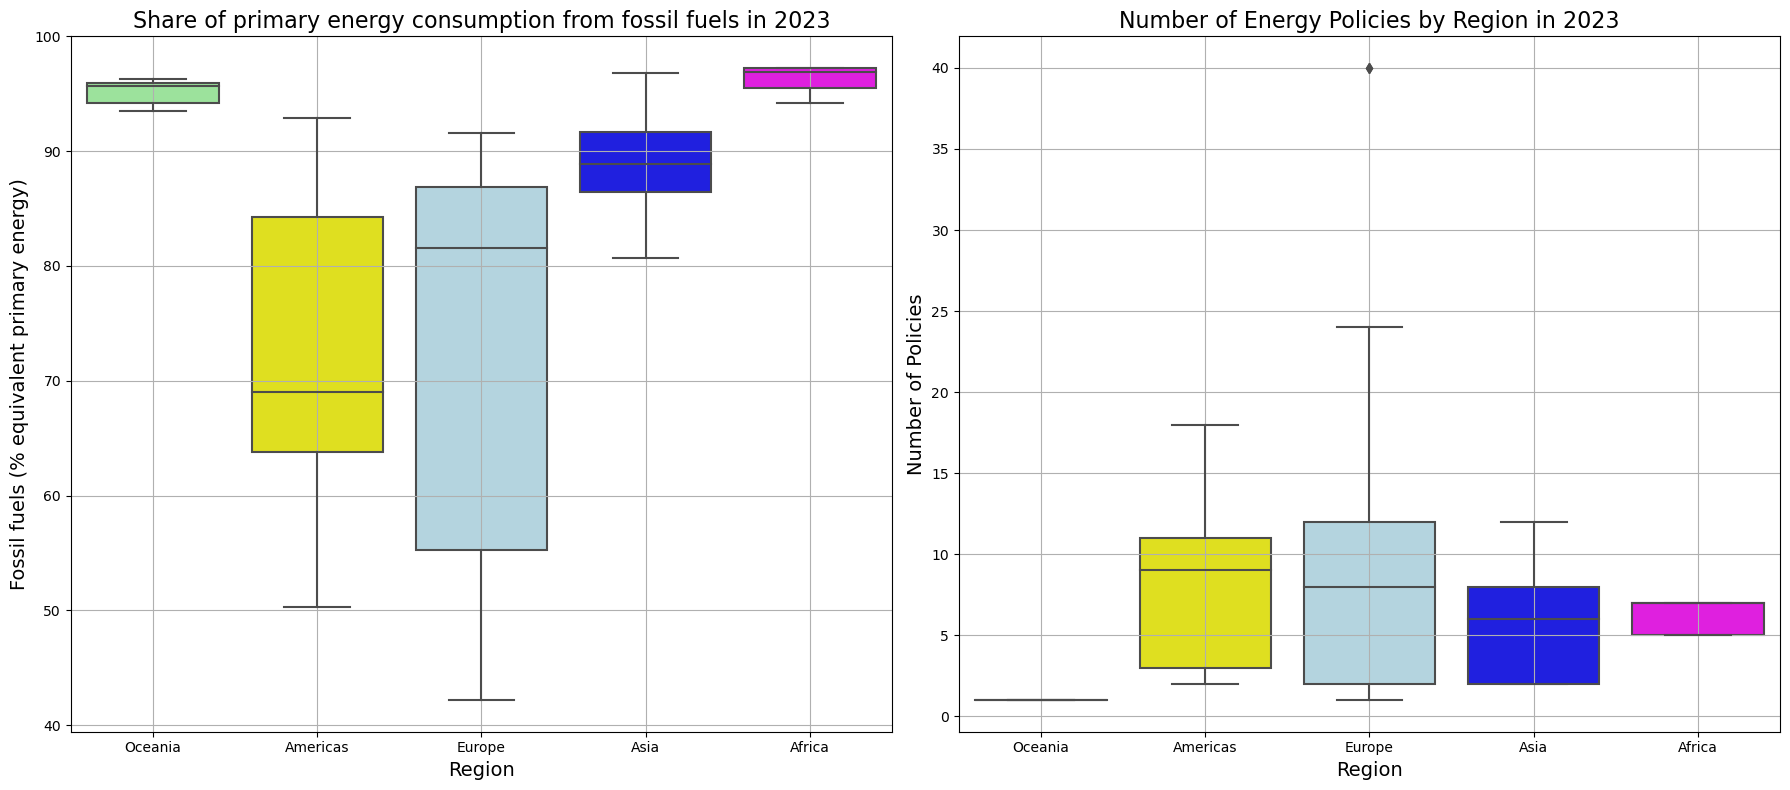

In [25]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Fossil fuels (% equivalent primary energy)',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of primary energy consumption from fossil fuels in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Fossil fuels (% equivalent primary energy)', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

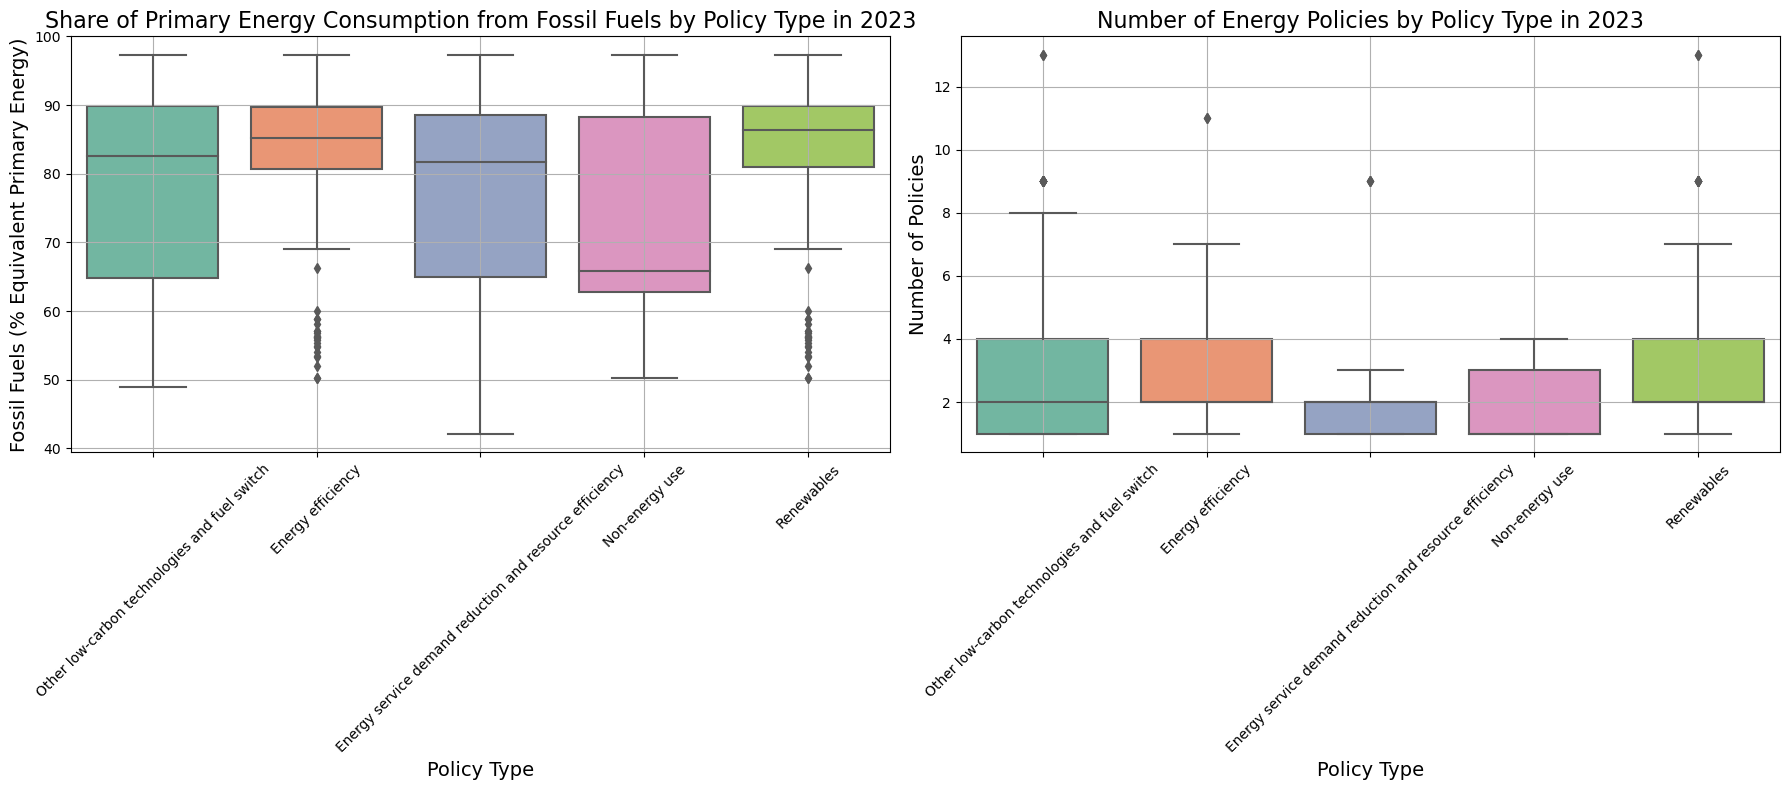

In [26]:
# Example of region_colors_fixed definition
# Assuming you have predefined colors for regions, you might need to define something similar for policy types.
# Here we'll just use a default color palette.

df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_fossil_policies.groupby(['country_iso', 'active_year', 'policy_type']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined_policy_type = pd.merge(
    df_share_energy_consum,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

policy_type_colors_fixed = sns.color_palette("Set2", n_colors=df_combined_policy_type['policy_type'].nunique())

# Function to create the box plots for renewable energy share and policy count by policy type
def plot_boxplots_by_policy_type(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='policy_type',
        y='Fossil fuels (% equivalent primary energy)',
        palette=policy_type_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of Primary Energy Consumption from Fossil Fuels by Policy Type in 2023', fontsize=16)
    axes[0].set_xlabel('Policy Type', fontsize=14)
    axes[0].set_ylabel('Fossil Fuels (% Equivalent Primary Energy)', fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='policy_type',
        y='policy_count',
        palette=policy_type_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Policy Type in 2023', fontsize=16)
    axes[1].set_xlabel('Policy Type', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_policy_type(df_combined_policy_type)

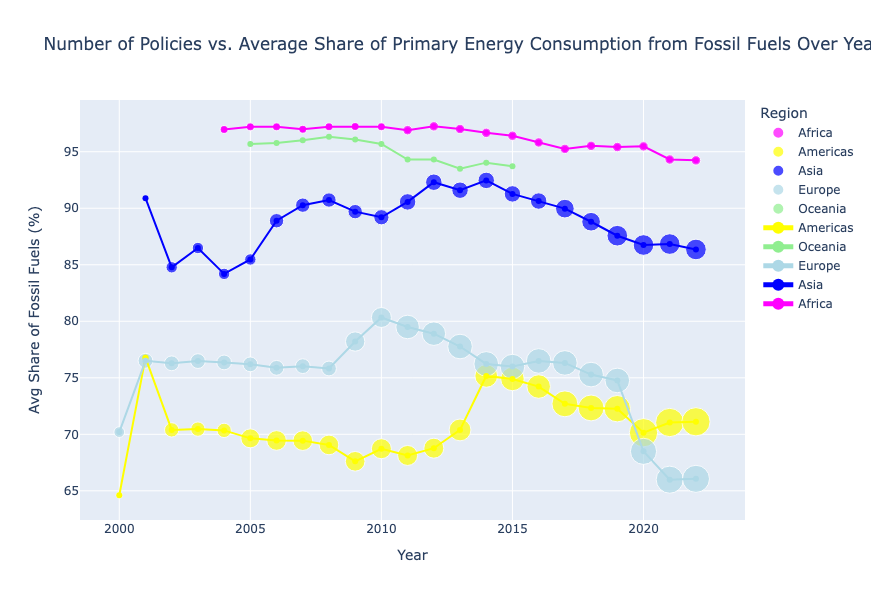

In [27]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Fossil fuels (% equivalent primary energy)': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
region_agg.rename(columns={'Fossil fuels (% equivalent primary energy)': 'Avg Share of Fossil Fuels'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_fossil_fuels_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Avg Share of Fossil Fuels',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Average Share of Primary Energy Consumption from Fossil Fuels Over Years',
        labels={'policy_count': 'Number of Policies', 'Avg Share of Fossil Fuels': 'Avg Share of Fossil Fuels (%)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Avg Share of Fossil Fuels'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Fossil Fuels: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Avg Share of Fossil Fuels (%)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_fossil_fuels_interactive(region_agg)

#### Number of Fossil Fuel Policies vs Share of electricity production from fossil fuels

In [28]:
df_share_energy_prod = pd.read_csv('new_data/energy/share-electricity-fossil-fuels.csv')
df_share_energy_prod = df_share_energy_prod.dropna()
df_share_energy_prod.head()

Entity Code  Year  Fossil fuels - % electricity
24  Afghanistan  AFG  2000                     35.416668
25  Afghanistan  AFG  2001                     27.536232
26  Afghanistan  AFG  2002                     21.126762
27  Afghanistan  AFG  2003                     30.769230
28  Afghanistan  AFG  2004                     29.113924

In [29]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_fossil_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_prod,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Fossil fuels - % electricity',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Fossil fuels - % electricity',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Fossil fuels - % electricity'])
    plt.title(f'Correlation between Number of Policies and Number of Energy Policies vs Share of electricity production from fossil fuels in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Fossil fuels - % electricity')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2023, min=2000), Output()), _dom_classes=…

In [30]:
calculate_and_store_data(df_combined, f'fossil_production', 'Fossil fuels - % electricity')

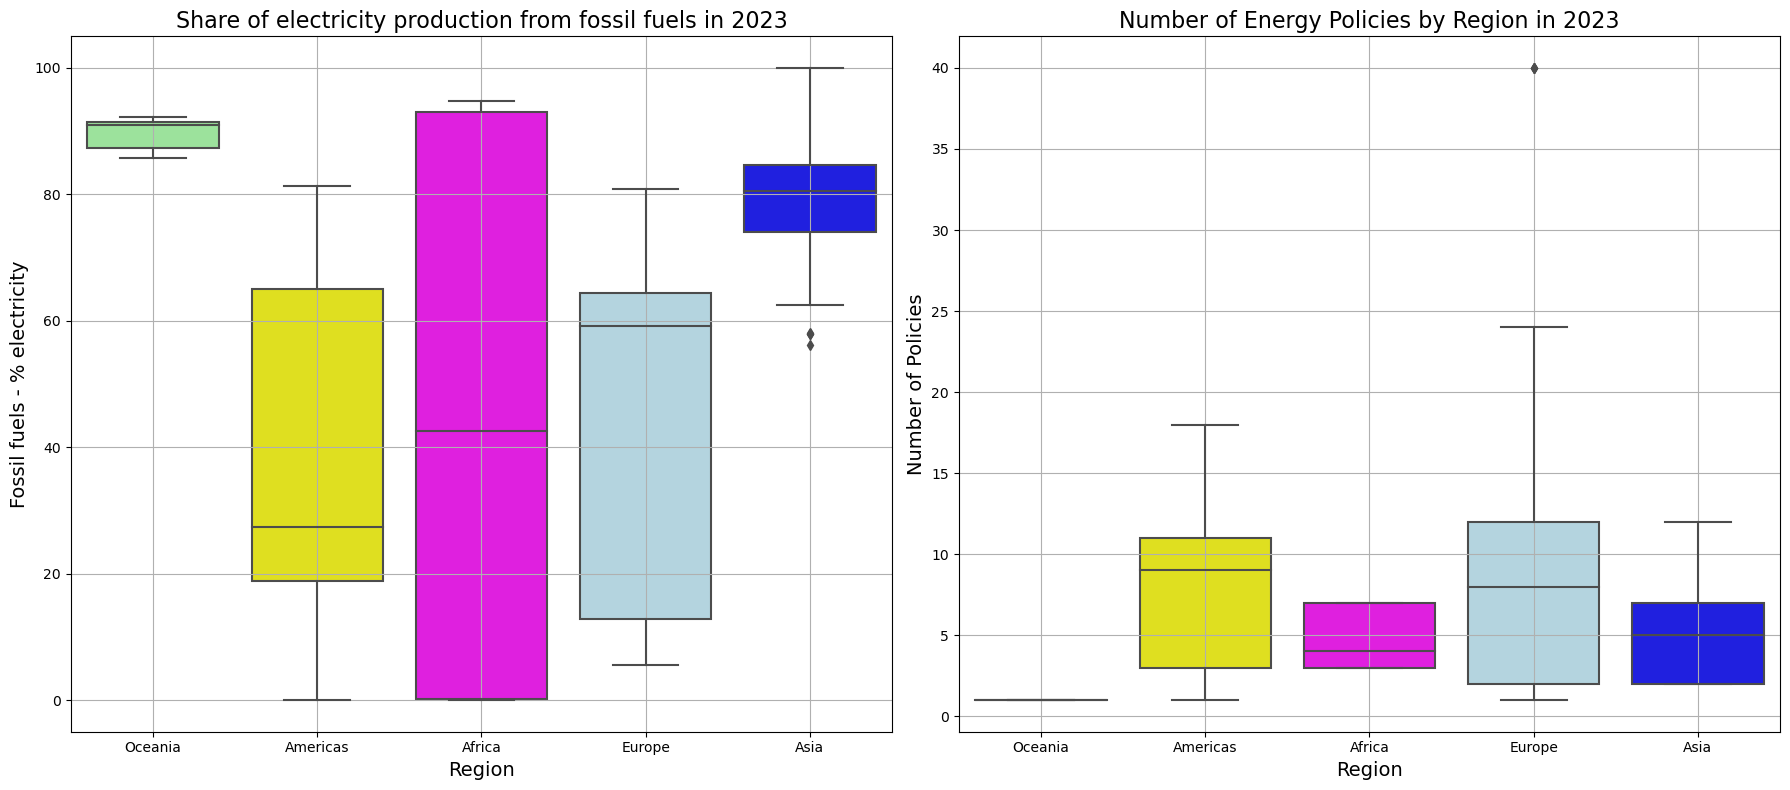

In [31]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Fossil fuels - % electricity',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of electricity production from fossil fuels in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Fossil fuels - % electricity', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

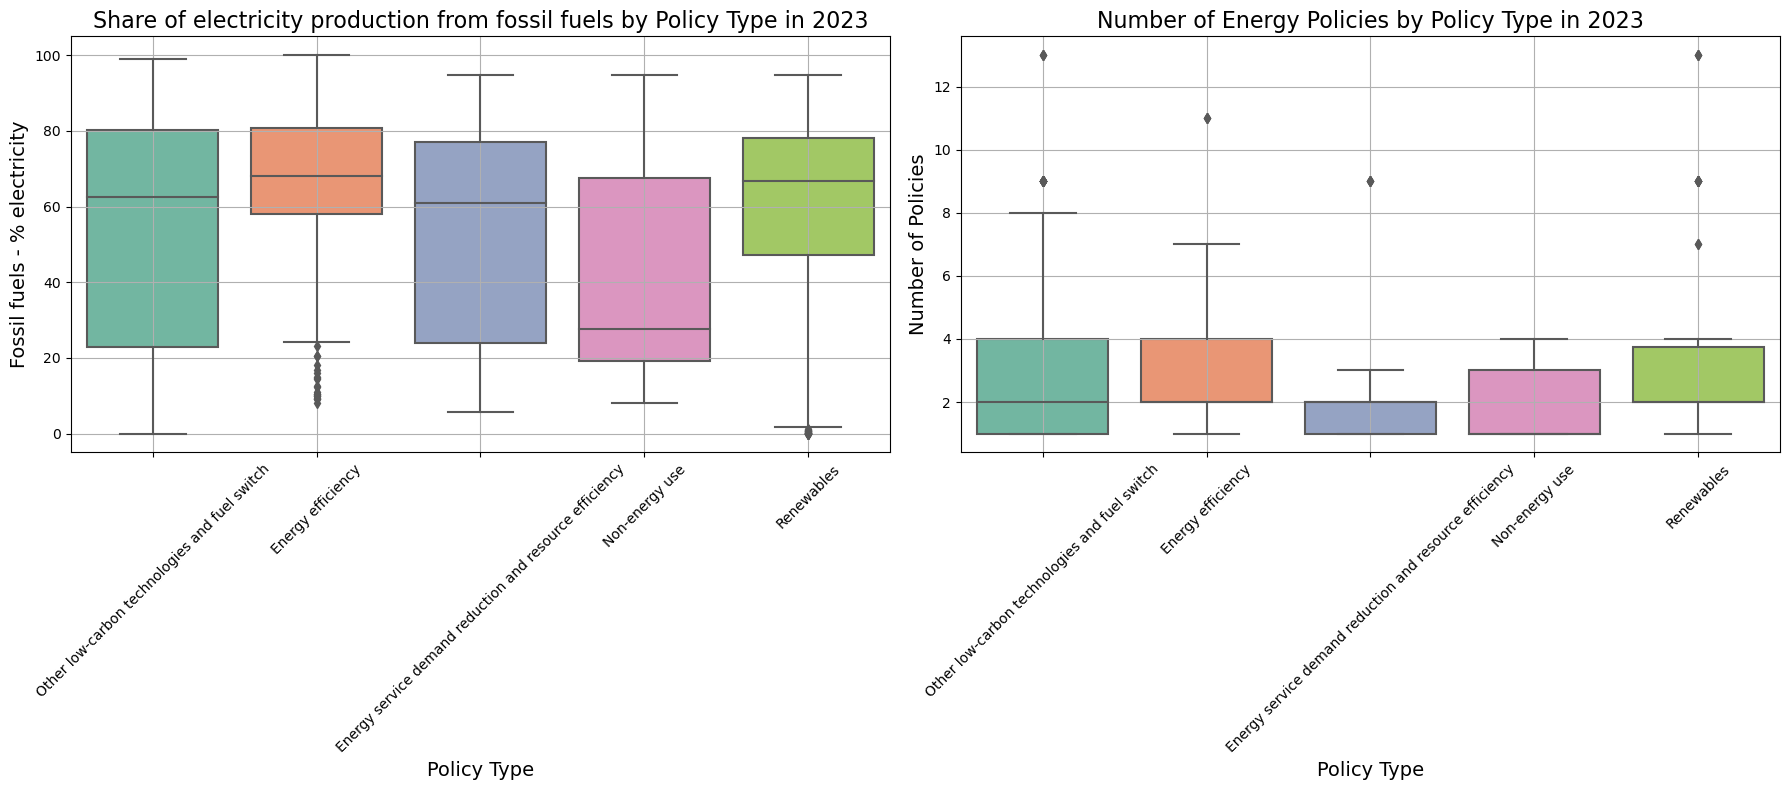

In [32]:
# Example of region_colors_fixed definition
# Assuming you have predefined colors for regions, you might need to define something similar for policy types.
# Here we'll just use a default color palette.

df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_fossil_policies.groupby(['country_iso', 'active_year', 'policy_type']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined_policy_type = pd.merge(
    df_share_energy_prod,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

policy_type_colors_fixed = sns.color_palette("Set2", n_colors=df_combined_policy_type['policy_type'].nunique())

# Function to create the box plots for renewable energy share and policy count by policy type
def plot_boxplots_by_policy_type(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='policy_type',
        y='Fossil fuels - % electricity',
        palette=policy_type_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of electricity production from fossil fuels by Policy Type in 2023', fontsize=16)
    axes[0].set_xlabel('Policy Type', fontsize=14)
    axes[0].set_ylabel('Fossil fuels - % electricity', fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='policy_type',
        y='policy_count',
        palette=policy_type_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Policy Type in 2023', fontsize=16)
    axes[1].set_xlabel('Policy Type', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_policy_type(df_combined_policy_type)

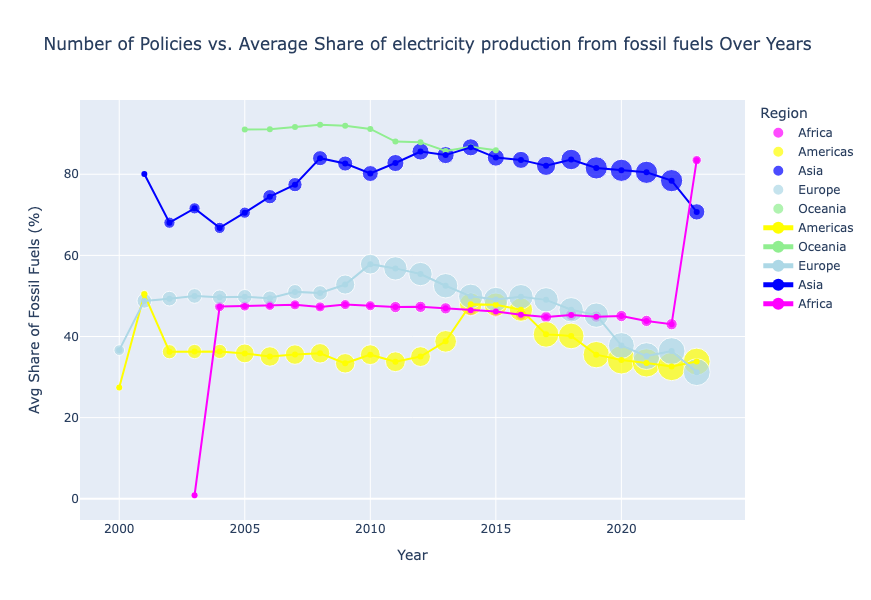

In [33]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Fossil fuels - % electricity': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
region_agg.rename(columns={'Fossil fuels - % electricity': 'Avg Share of Fossil Fuels'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_fossil_fuels_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Avg Share of Fossil Fuels',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Average Share of electricity production from fossil fuels Over Years',
        labels={'policy_count': 'Number of Policies', 'Avg Share of Fossil Fuels': 'Avg Share of Fossil Fuels (%)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Avg Share of Fossil Fuels'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Fossil Fuels: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Avg Share of Fossil Fuels (%)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_fossil_fuels_interactive(region_agg)

#### Number of Nuclear Energy Policies vs Share of primary energy consumption from nuclear

In [34]:
df_nuclear_policies = df_sub[df_sub["sector"] == "Nuclear"]
df_nuclear_policies.head()

country_iso country_update  \
3847         CAN         Annual   
3987         CAN         Annual   
4146         CAN         Annual   
4305         CAN         Annual   
4469         CAN         Annual   

                                           policy_title jurisdiction country  \
3847  Multilateral Development of Gen IV Nuclear Pow...      Country  Canada   
3987  Multilateral Development of Gen IV Nuclear Pow...      Country  Canada   
4146  Multilateral Development of Gen IV Nuclear Pow...      Country  Canada   
4305  Multilateral Development of Gen IV Nuclear Pow...      Country  Canada   
4469  Multilateral Development of Gen IV Nuclear Pow...      Country  Canada   

      policy_instrument   sector policy_description  \
3847  Direct investment  Nuclear                NaN   
3987  Direct investment  Nuclear                NaN   
4146  Direct investment  Nuclear                NaN   
4305  Direct investment  Nuclear                NaN   
4469  Direct investment  Nuclear                NaN   

                                        policy_type policy_status  ...  VarID  \
3847  Other low-carbon technologies and fuel switch      In force  ...      2   
3987  Other low-carbon technologies and fuel switch      In force  ...      2   
4146  Other low-carbon technologies and fuel switch      In force  ...      2   
4305  Other low-carbon technologies and fuel switch      In force  ...      2   
4469  Other low-carbon technologies and fuel switch      In force  ...      2   

      Variant  Time MidPeriod    PopMale  PopFemale   PopTotal  PopDensity  \
3847   Medium  2005    2005.5  15945.444  16218.869  32164.313       3.537   
3987   Medium  2006    2006.5  16133.439  16403.555  32536.994       3.578   
4146   Medium  2007    2007.5  16332.207  16598.588  32930.795       3.621   
4305   Medium  2008    2008.5  16537.195  16800.443  33337.638       3.666   
4469   Medium  2009    2009.5  16741.973  17004.120  33746.093       3.711   

                      sector_group policy_instrument_group  
3847  Energy Production and Supply    Economic Instruments  
3987  Energy Production and Supply    Economic Instruments  
4146  Energy Production and Supply    Economic Instruments  
4305  Energy Production and Supply    Economic Instruments  
4469  Energy Production and Supply    Economic Instruments  

[5 rows x 38 columns]

In [35]:
df_share_energy_consum = pd.read_csv('new_data/energy/nuclear-primary-energy.csv')
df_share_energy_consum = df_share_energy_consum.dropna()
df_share_energy_consum.head()

Entity Code  Year  Nuclear (% equivalent primary energy)
116  Algeria  DZA  1965                                    0.0
117  Algeria  DZA  1966                                    0.0
118  Algeria  DZA  1967                                    0.0
119  Algeria  DZA  1968                                    0.0
120  Algeria  DZA  1969                                    0.0

In [36]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_nuclear_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_nuclear_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_consum,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Nuclear (% equivalent primary energy)',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Nuclear (% equivalent primary energy)',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Nuclear (% equivalent primary energy)'])
    plt.title(f'Correlation between Number of Policies and Share of primary energy consumption from nuclear in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Nuclear (% equivalent primary energy)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2022, min=2000), Output()), _dom_classes=…

In [37]:
calculate_and_store_data(df_combined, f'nuclear_consumption', 'Nuclear (% equivalent primary energy)')

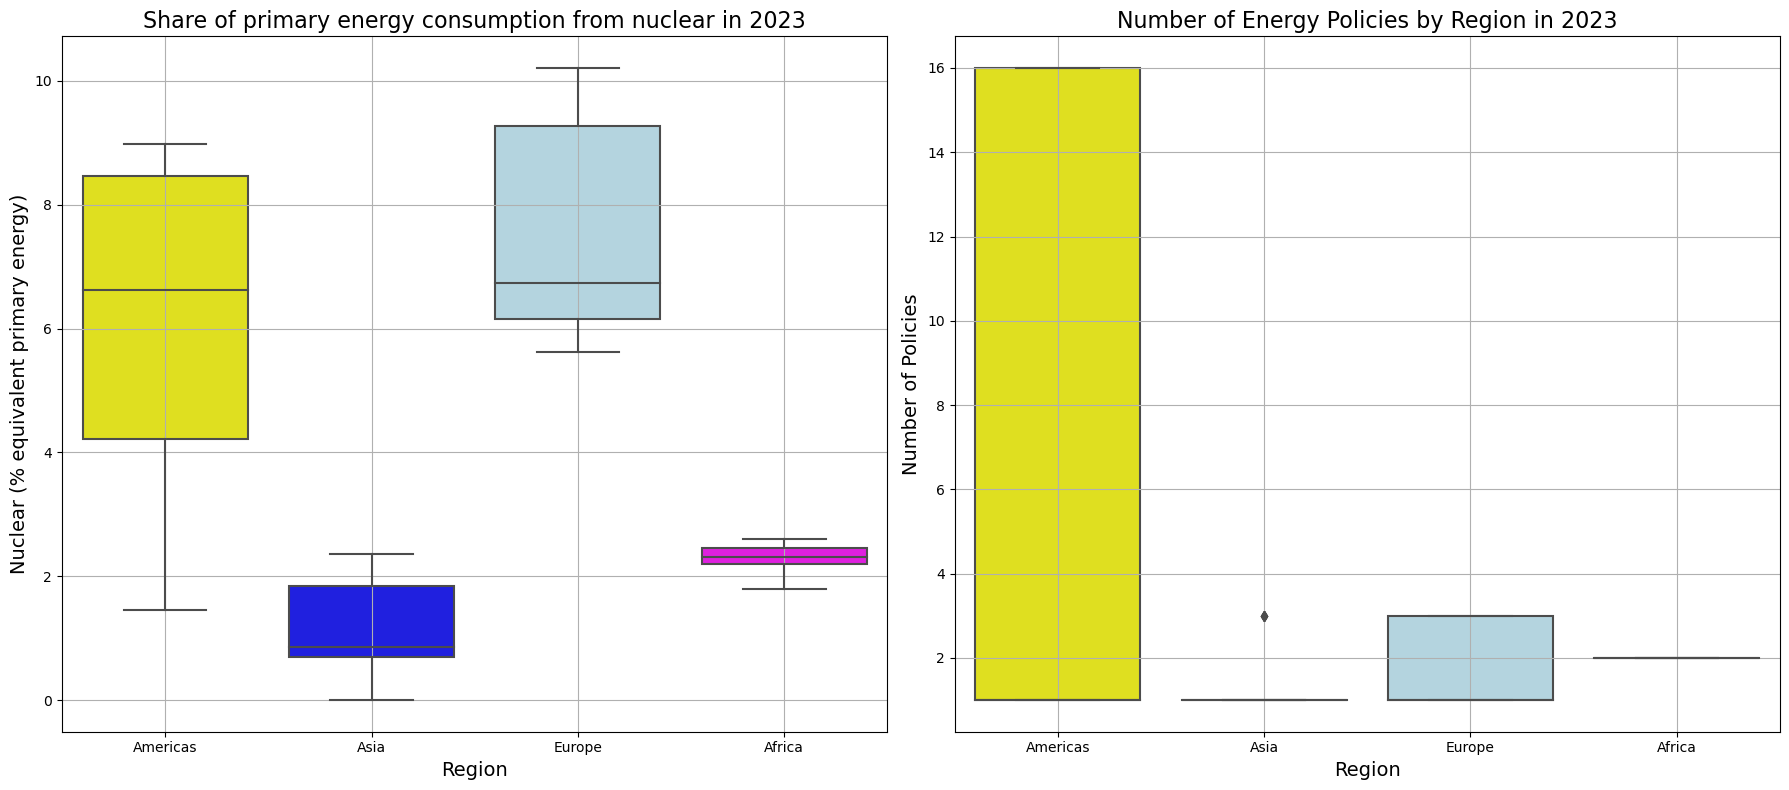

In [38]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Nuclear (% equivalent primary energy)',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of primary energy consumption from nuclear in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Nuclear (% equivalent primary energy)', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

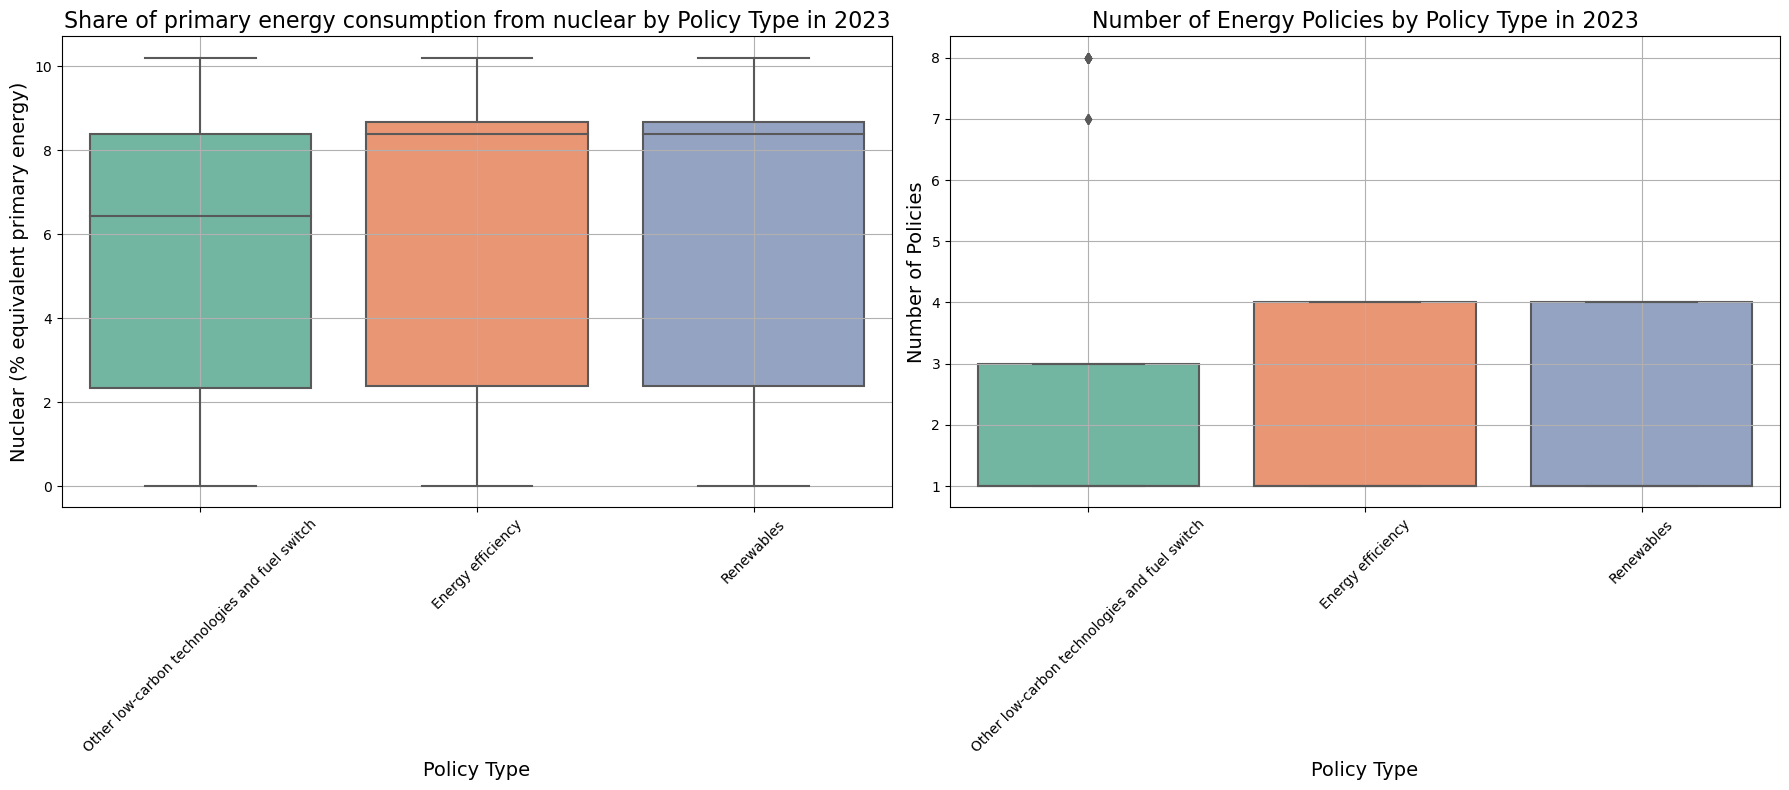

In [39]:
# Example of region_colors_fixed definition
# Assuming you have predefined colors for regions, you might need to define something similar for policy types.
# Here we'll just use a default color palette.

df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_nuclear_policies.groupby(['country_iso', 'active_year', 'policy_type']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined_policy_type = pd.merge(
    df_share_energy_consum,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

policy_type_colors_fixed = sns.color_palette("Set2", n_colors=df_combined_policy_type['policy_type'].nunique())

# Function to create the box plots for renewable energy share and policy count by policy type
def plot_boxplots_by_policy_type(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='policy_type',
        y='Nuclear (% equivalent primary energy)',
        palette=policy_type_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of primary energy consumption from nuclear by Policy Type in 2023', fontsize=16)
    axes[0].set_xlabel('Policy Type', fontsize=14)
    axes[0].set_ylabel('Nuclear (% equivalent primary energy)', fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='policy_type',
        y='policy_count',
        palette=policy_type_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Policy Type in 2023', fontsize=16)
    axes[1].set_xlabel('Policy Type', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_policy_type(df_combined_policy_type)

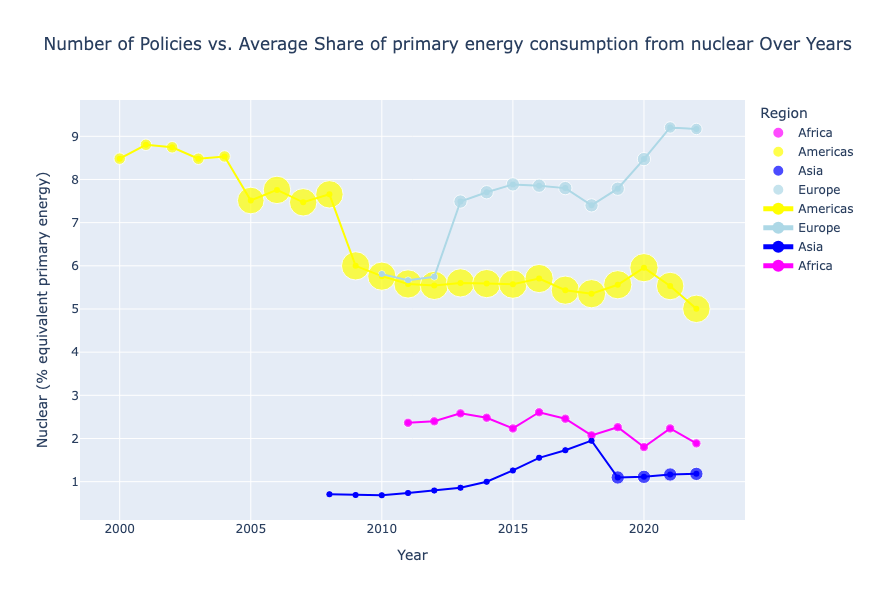

In [40]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Nuclear (% equivalent primary energy)': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Nuclear (% equivalent primary energy)': 'Avg Share of Fossil Fuels'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_nuclear_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Nuclear (% equivalent primary energy)',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Average Share of primary energy consumption from nuclear Over Years',
        labels={'policy_count': 'Number of Policies', 'Nuclear (% equivalent primary energy)' :'Nuclear (% equivalent primary energy)'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Nuclear (% equivalent primary energy)'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Nuclear: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Nuclear (% equivalent primary energy)',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_nuclear_interactive(region_agg)

#### Number of Nuclear Energy Policies vs Share of electricity production from nuclear

In [41]:
df_share_energy_prod = pd.read_csv('new_data/energy/share-electricity-nuclear.csv')
df_share_energy_prod = df_share_energy_prod.dropna()
df_share_energy_prod.head()

Entity Code  Year  Nuclear - % electricity
24  Afghanistan  AFG  2000                      0.0
25  Afghanistan  AFG  2001                      0.0
26  Afghanistan  AFG  2002                      0.0
27  Afghanistan  AFG  2003                      0.0
28  Afghanistan  AFG  2004                      0.0

In [42]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_fossil_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_fossil_policies.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_share_energy_prod,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Nuclear - % electricity',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Nuclear - % electricity',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Nuclear - % electricity'])
    plt.title(f'Correlation between Number of Policies and Number of Energy Policies vs Share of electricity production from nuclear in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Nuclear - % electricity')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2023, min=2000), Output()), _dom_classes=…

In [43]:
calculate_and_store_data(df_combined, f'nuclear_production', 'Nuclear - % electricity')

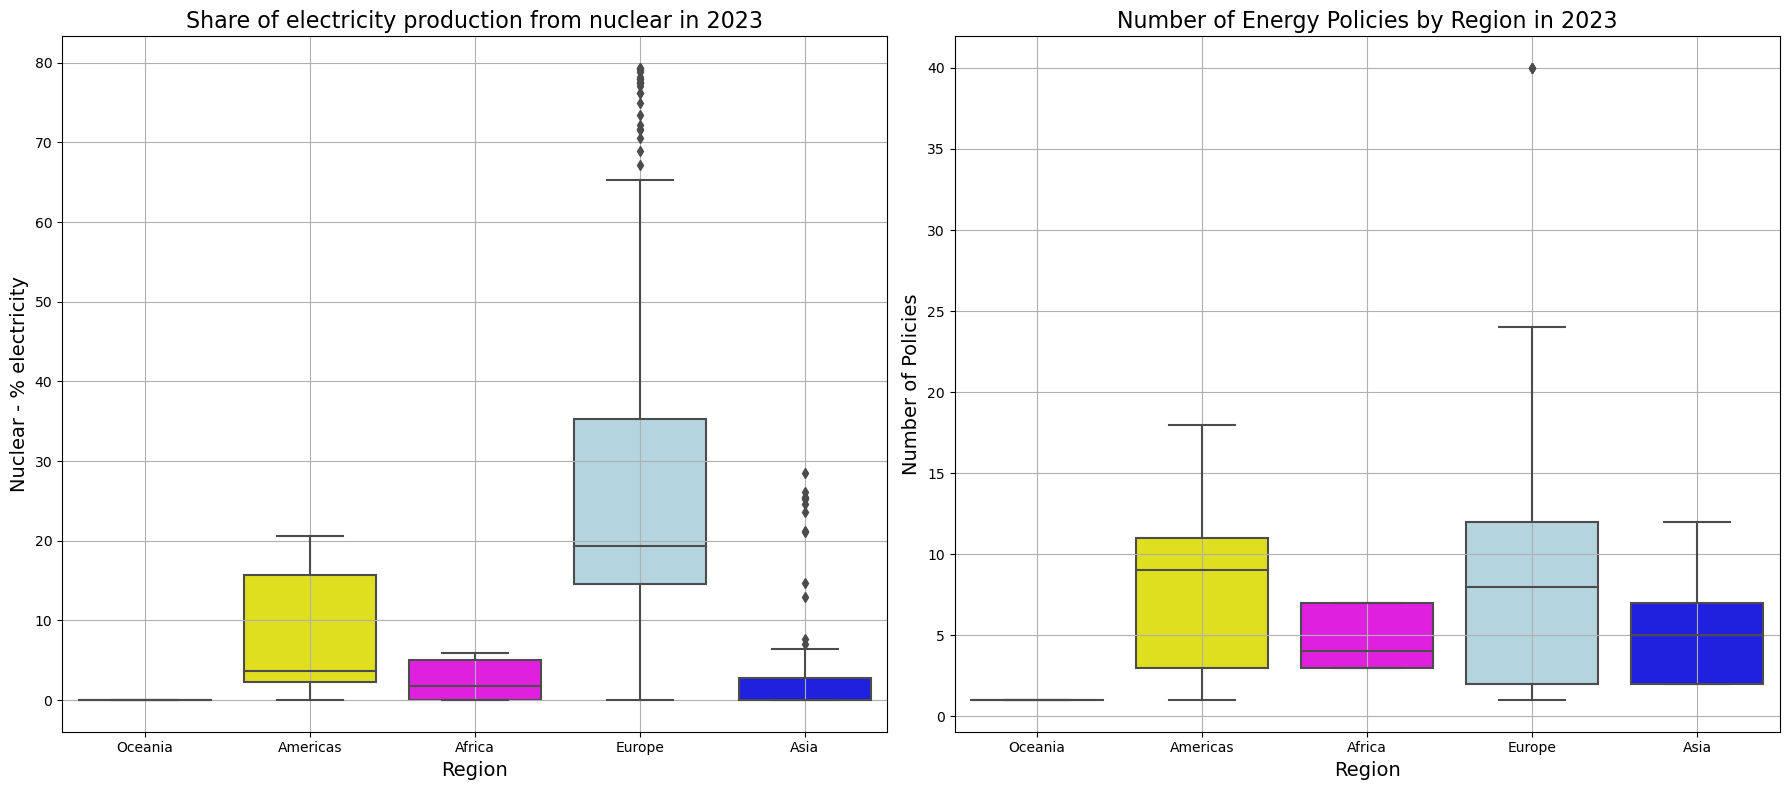

In [44]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Nuclear - % electricity',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of electricity production from nuclear in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Nuclear - % electricity', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

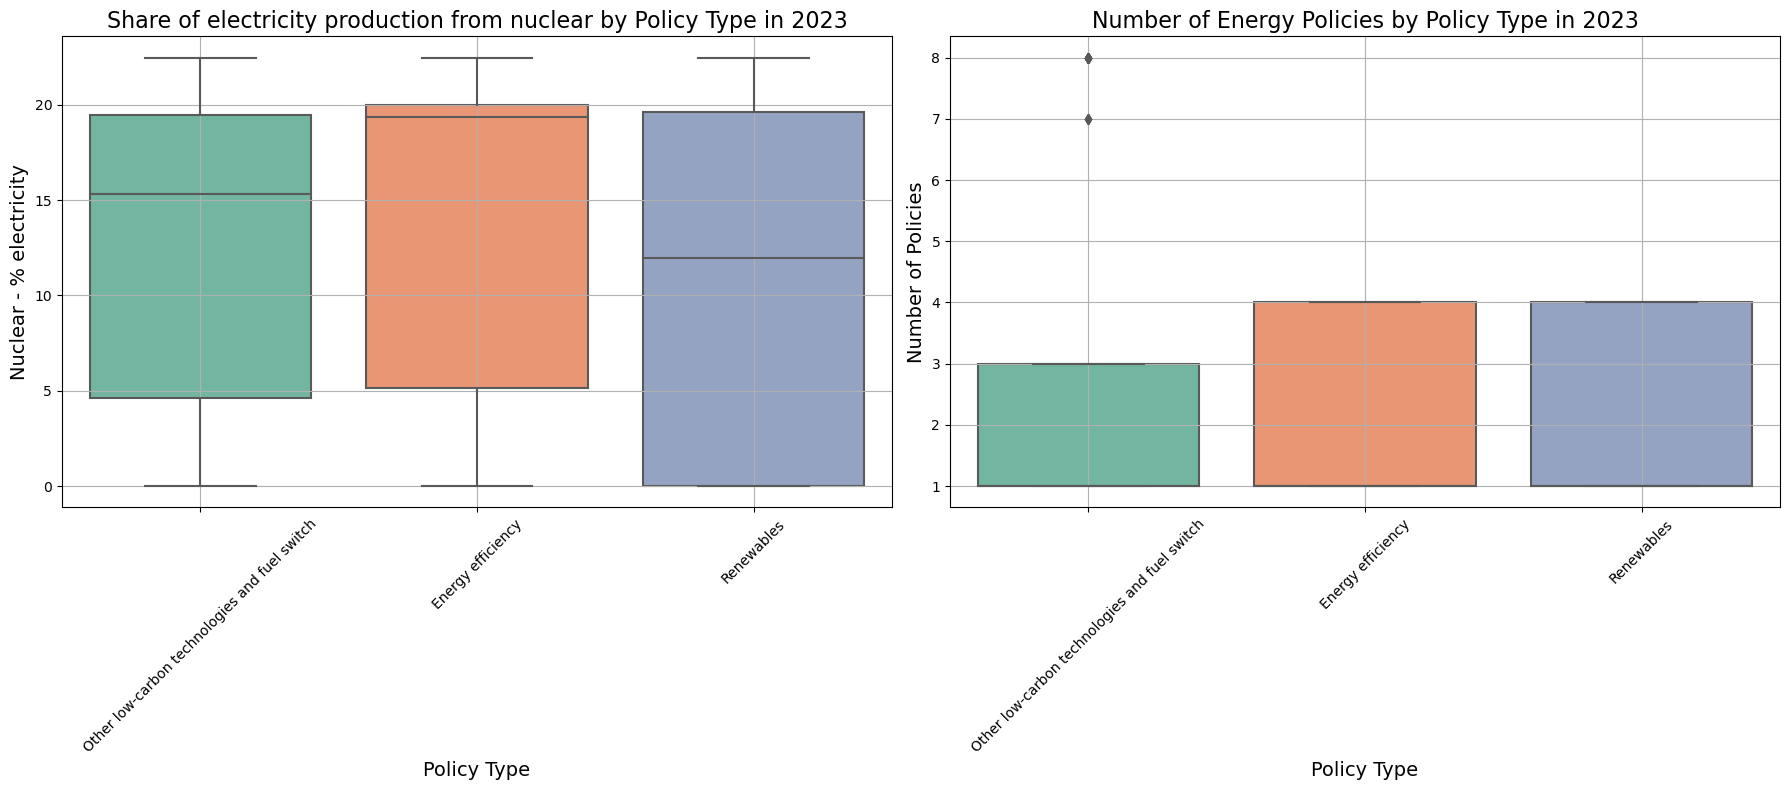

In [45]:
# Example of region_colors_fixed definition
# Assuming you have predefined colors for regions, you might need to define something similar for policy types.
# Here we'll just use a default color palette.

df_nuclear_policies['policy_count'] = 1  # Add a column to count policies
policies_agg = df_nuclear_policies.groupby(['country_iso', 'active_year', 'policy_type']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined_policy_type = pd.merge(
    df_share_energy_prod,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

policy_type_colors_fixed = sns.color_palette("Set2", n_colors=df_combined_policy_type['policy_type'].nunique())

# Function to create the box plots for renewable energy share and policy count by policy type
def plot_boxplots_by_policy_type(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='policy_type',
        y='Nuclear - % electricity',
        palette=policy_type_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Share of electricity production from nuclear by Policy Type in 2023', fontsize=16)
    axes[0].set_xlabel('Policy Type', fontsize=14)
    axes[0].set_ylabel('Nuclear - % electricity', fontsize=14)
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='policy_type',
        y='policy_count',
        palette=policy_type_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Policy Type in 2023', fontsize=16)
    axes[1].set_xlabel('Policy Type', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_policy_type(df_combined_policy_type)

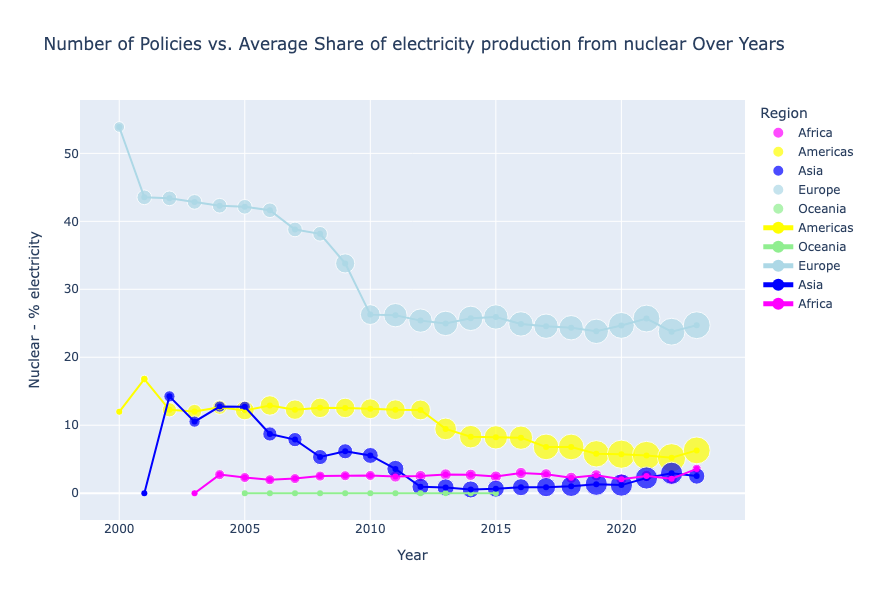

In [46]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Nuclear - % electricity': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_nuclear_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Nuclear - % electricity',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Average Share of electricity production from nuclear Over Years',
        labels={'policy_count': 'Number of Policies', 'Nuclear - % electricity': 'Nuclear - % electricity'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Nuclear - % electricity'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Nuclear: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Nuclear - % electricity',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_nuclear_interactive(region_agg)

#### Number of Energy Policies vs CO₂ and Greenhouse Gas Emissions

In [47]:
df_ghg_emission = pd.read_csv('new_data/energy/per-capita-ghg-emissions.csv')
df_ghg_emission = df_ghg_emission.dropna()
df_ghg_emission.head()

Entity Code  Year  \
0  Afghanistan  AFG  1850   
1  Afghanistan  AFG  1851   
2  Afghanistan  AFG  1852   
3  Afghanistan  AFG  1853   
4  Afghanistan  AFG  1854   

   Per-capita greenhouse gas emissions in CO₂ equivalents  
0                                           1.955458       
1                                           1.964986       
2                                           1.972589       
3                                           1.979090       
4                                           1.985106

In [48]:
# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Prepare the data
df_sub['policy_count'] = 1  # Add a column to count policies
policies_agg = df_sub.groupby(['country_iso', 'active_year', 'region']).agg({'policy_count': 'sum'}).reset_index()

# Merge with the renewable energy consumption data
df_combined = pd.merge(
    df_ghg_emission,
    policies_agg,
    left_on=['Code', 'Year'],
    right_on=['country_iso', 'active_year']
)

df_combined = df_combined[df_combined["Year"] >= 2000]

# Function to plot the correlation with fixed region colors
def plot_correlation_fixed_colors(df, year):
    # Filter the data for the selected year
    df_year = df[df['Year'] == year]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_year,
        x='policy_count',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        hue='region',
        palette=region_colors_fixed,
        s=100
    )
    
    # Add a regression line
    sns.regplot(
        data=df_year,
        x='policy_count',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        scatter=False,
        ax=scatter_plot
    )
    
    # Calculate and display correlation
    correlation = df_year['policy_count'].corr(df_year['Per-capita greenhouse gas emissions in CO₂ equivalents'])
    plt.title(f'Correlation between Number of Policies and Number of Energy Policies vs Per-capita greenhouse gas emissions in CO₂ equivalents in {year}\nCorrelation: {correlation:.2f}', fontsize=14)
    
    plt.xlabel('Number of Policies')
    plt.ylabel('Per-capita greenhouse gas emissions in CO₂ equivalents')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Create a dropdown widget for year selection
year_selector_fixed_colors = widgets.IntSlider(
    min=df_combined['Year'].min(),
    max=df_combined['Year'].max(),
    step=1,
    value=df_combined['Year'].min(),
    description='Year:'
)

# Link the dropdown to the plot function with fixed colors
def interactive_plot_fixed_colors(year):
    plot_correlation_fixed_colors(df_combined, year)

# Display the interactive plot
widgets.interactive(interactive_plot_fixed_colors, year=year_selector_fixed_colors)

interactive(children=(IntSlider(value=2000, description='Year:', max=2022, min=2000), Output()), _dom_classes=…

In [49]:
calculate_and_store_data(df_combined, f'ghg_emissions', 'Per-capita greenhouse gas emissions in CO₂ equivalents')

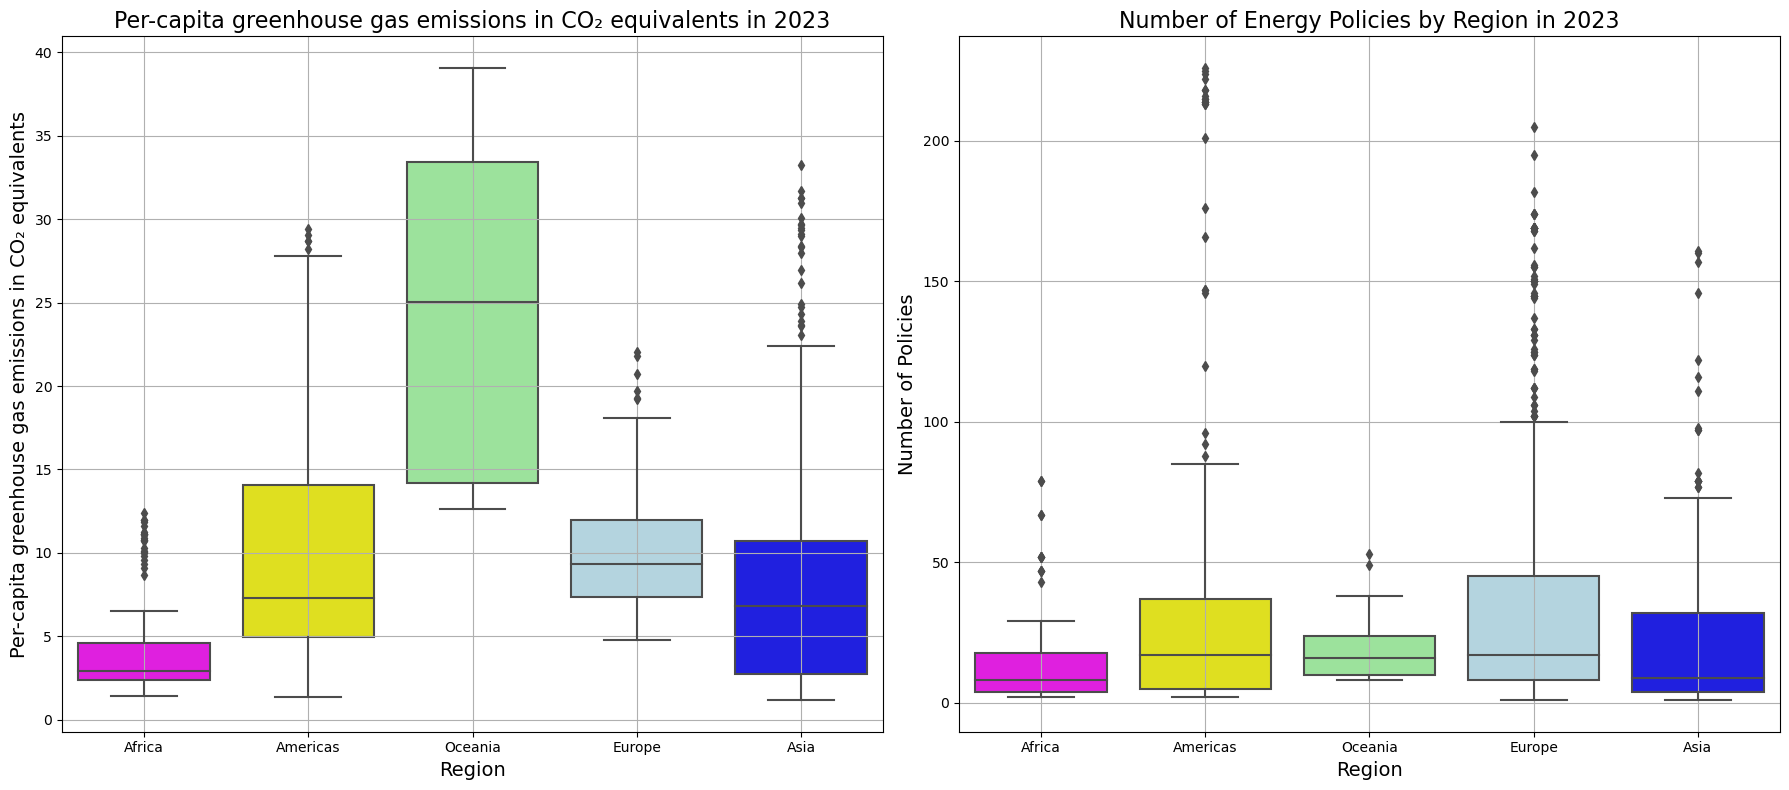

In [50]:
# Function to create the box plots for renewable energy share and policy count by region
def plot_boxplots_by_region(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot for renewable energy share
    sns.boxplot(
        data=df,
        x='region',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        palette=region_colors_fixed,
        ax=axes[0]
    )
    axes[0].set_title('Per-capita greenhouse gas emissions in CO₂ equivalents in 2023', fontsize=16)
    axes[0].set_xlabel('Region', fontsize=14)
    axes[0].set_ylabel('Per-capita greenhouse gas emissions in CO₂ equivalents', fontsize=14)
    axes[0].grid(True)

    # Plot for policy count
    sns.boxplot(
        data=df,
        x='region',
        y='policy_count',
        palette=region_colors_fixed,
        ax=axes[1]
    )
    axes[1].set_title('Number of Energy Policies by Region in 2023', fontsize=16)
    axes[1].set_xlabel('Region', fontsize=14)
    axes[1].set_ylabel('Number of Policies', fontsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the box plots
plot_boxplots_by_region(df_combined)

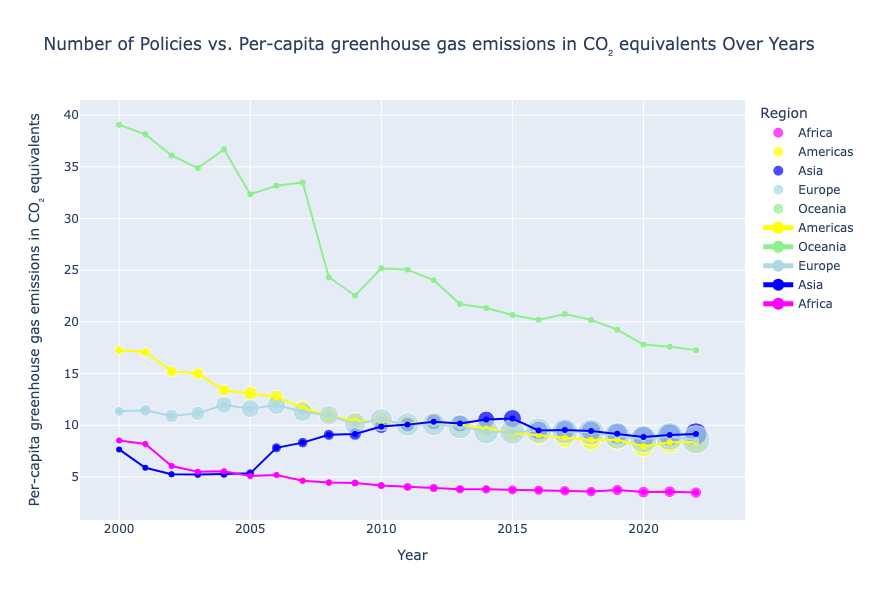

In [51]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_combined is already prepared as per your provided code
# Aggregate the data by region and year
region_agg = df_combined.groupby(['region', 'Year']).agg({
    'policy_count': 'sum',  # Total number of policies
    'Per-capita greenhouse gas emissions in CO₂ equivalents': 'mean'  # Average share of renewable energy consumption
}).reset_index()

# Rename the column for clarity
# region_agg.rename(columns={'Per-capita greenhouse gas emissions in CO₂ equivalents': 'Per-capita greenhouse gas emissions in CO₂ equivalents'}, inplace=True)

# Define the custom color palette for each region
region_colors_fixed = {
    'Americas': 'yellow',
    'Oceania': 'lightgreen',
    'Europe': 'lightblue',
    'Asia': 'blue',
    'Africa': 'magenta'
}

# Function to plot number of policies vs. avg share of renewables over years by region
def plot_policies_vs_ghg_interactive(region_agg):
    # Create a scatter plot with lines
    fig = px.scatter(
        region_agg,
        x='Year',
        y='Per-capita greenhouse gas emissions in CO₂ equivalents',
        color='region',
        size='policy_count',
        color_discrete_map=region_colors_fixed,
        title='Number of Policies vs. Per-capita greenhouse gas emissions in CO₂ equivalents Over Years',
        labels={'policy_count': 'Number of Policies', 'Per-capita greenhouse gas emissions in CO₂ equivalents': 'Per-capita greenhouse gas emissions in CO₂ equivalents'}
    )
    
    # Add lines for each region
    for region in region_colors_fixed.keys():
        region_data = region_agg[region_agg['region'] == region]
        fig.add_trace(go.Scatter(
            x=region_data['Year'],
            y=region_data['Per-capita greenhouse gas emissions in CO₂ equivalents'],
            mode='lines+markers',
            name=region,
            marker=dict(color=region_colors_fixed[region]),
            line=dict(color=region_colors_fixed[region]),
            text=region_data['policy_count'],  # Hover text will show number of policies
            hovertemplate='Year: %{x}<br>Avg Share of Fossil Fuels: %{y:.2f}%<br>Number of Policies: %{text}<extra></extra>'
        ))
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Per-capita greenhouse gas emissions in CO₂ equivalents',
        legend_title='Region',
        hovermode='x unified',
        height=600
    )
    
    fig.show()

# Call the plotting function with the refined approach
plot_policies_vs_ghg_interactive(region_agg)

### Save data

In [52]:
df = pd.DataFrame(data)
df.to_csv('out/1.3_policy_instrument.csv', index=False)